In [1]:
import numpy as np
import scipy.linalg as linalg
from matplotlib import pyplot as plt
from scipy.linalg import svd

from ssa_methods.ssa_classic import SSA_classic

import pandas as pd

# auxilaty plotting functions
from ssa_methods.ssa_complementary.plotting import *
# partition finding algorithms
from ssa_methods.ssa_complementary.ssa_classic_partition import *

%matplotlib inline 
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 13})

### Build synthetic signal

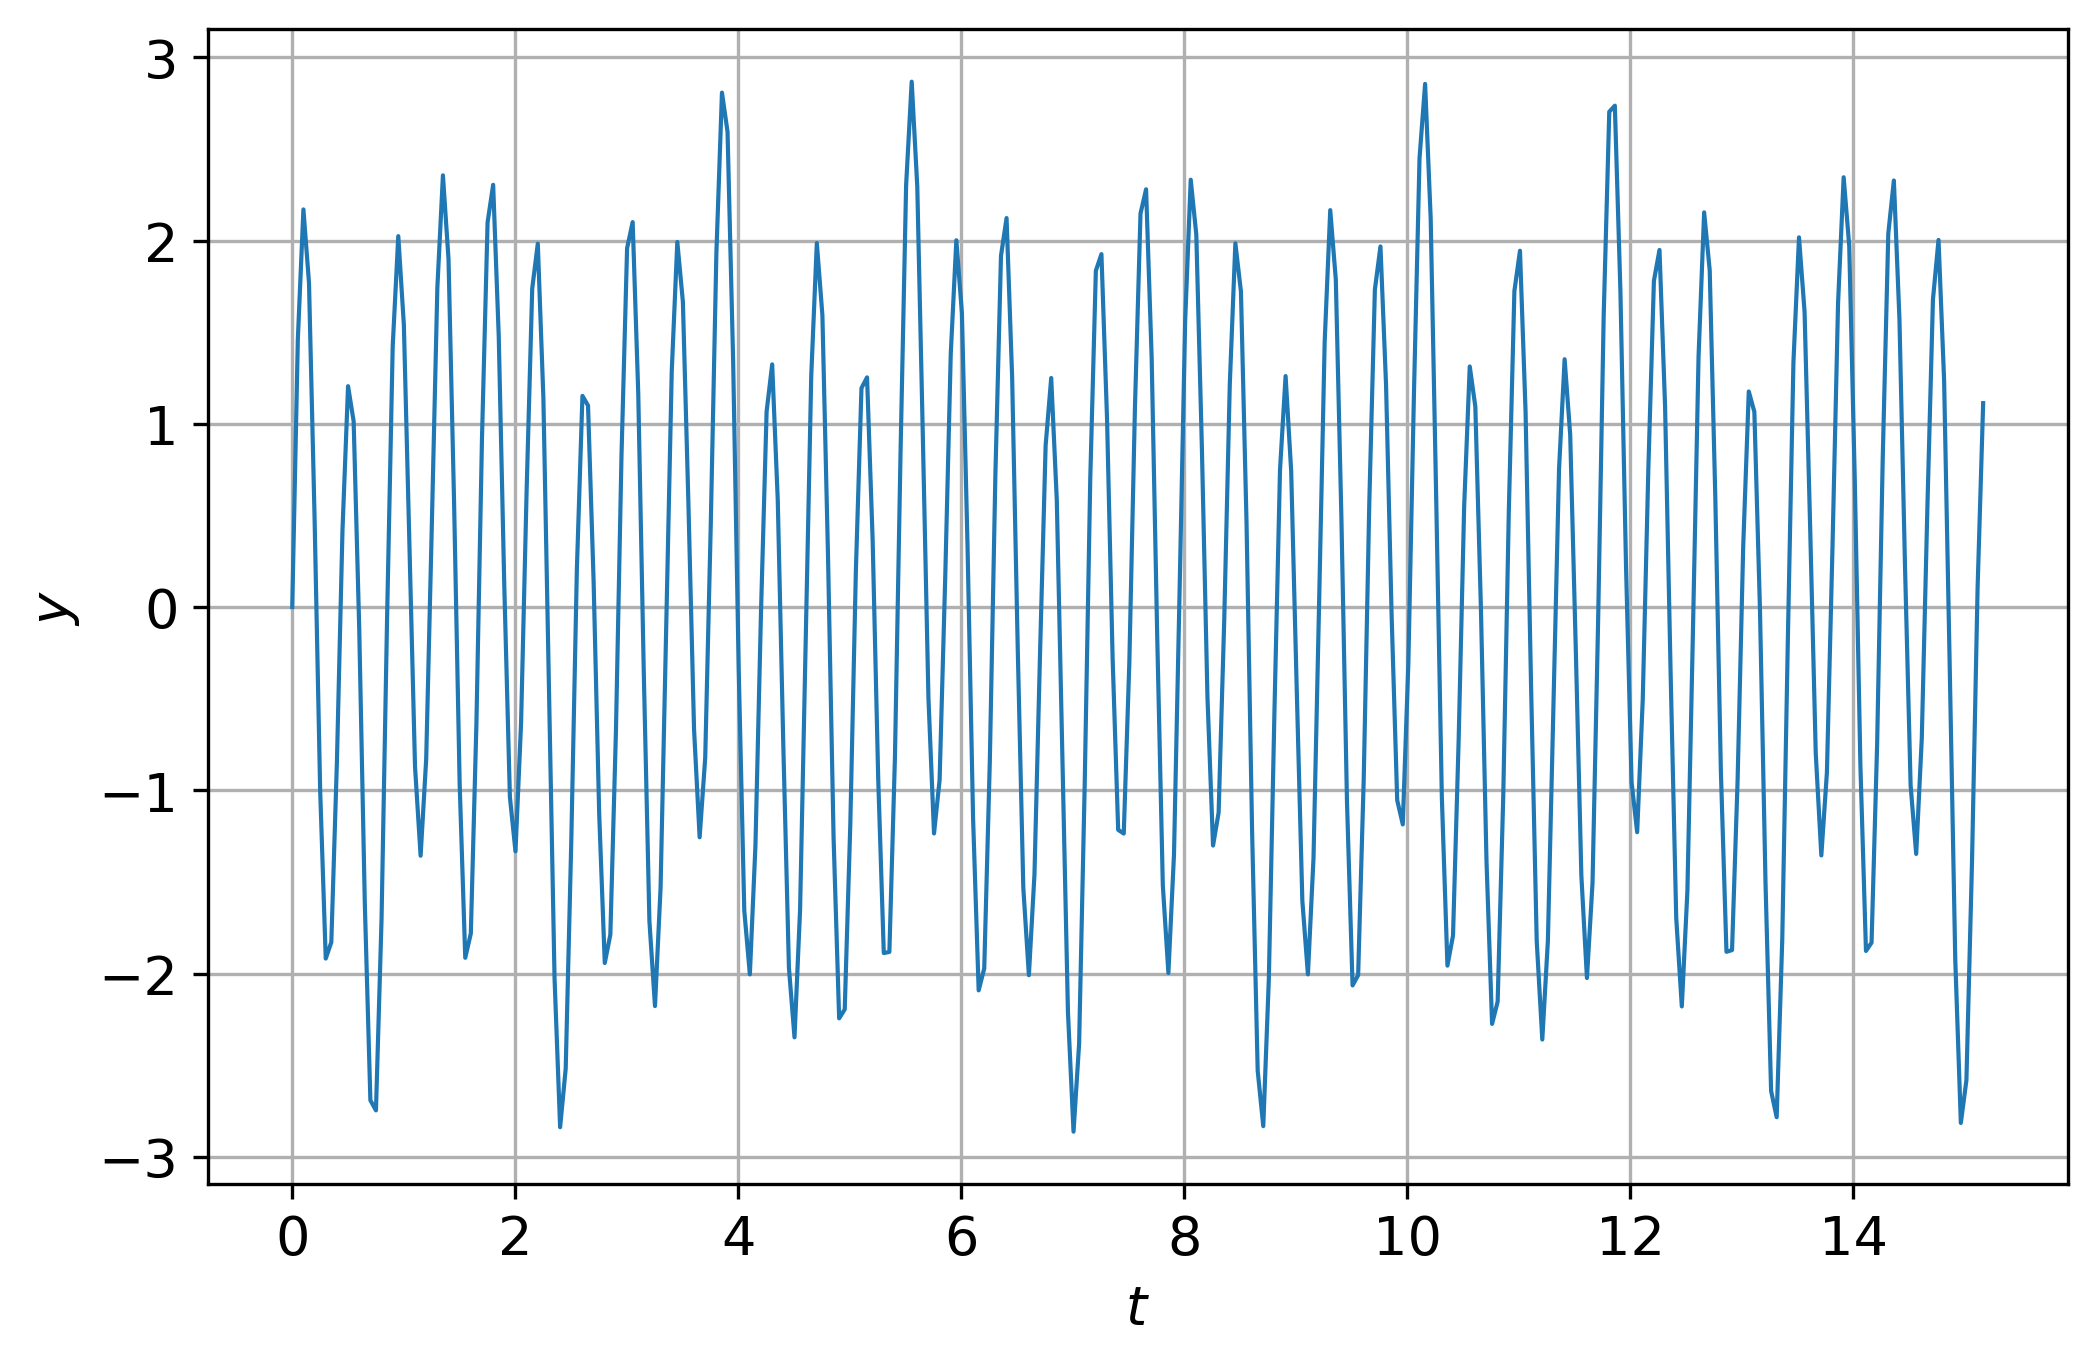

In [2]:
plt.rcParams.update({'lines.linewidth': 1})
# size of the signal
grid_size = 1000
# end time point
grid_end = 50

time_grid = np.linspace(0, grid_end, grid_size)
signal = np.sin(2 * time_grid) * np.cos(5 * time_grid) + 2 * np.sin(15 * time_grid)

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(time_grid[:304], signal[:304])
ax.set_xlabel('$t$')
ax.set_ylabel('$y$')
ax.grid(True)

fig.savefig('../figs/experiment/ssa_classic_prediction_invariant/test_signal.png', format='png')

### Initiate SSA object

In [3]:
# ssa parameter - window size
L = 80

ssa_obj = SSA_classic(signal, L)
# build and make svd for trajectory matrix
ssa_obj.decompose_tm()

(<Figure size 2400x1500 with 1 Axes>,
 <Axes: title={'center': 'Available singular values of trajectory matrix'}, xlabel='Singular value number', ylabel='$\\sigma$'>)

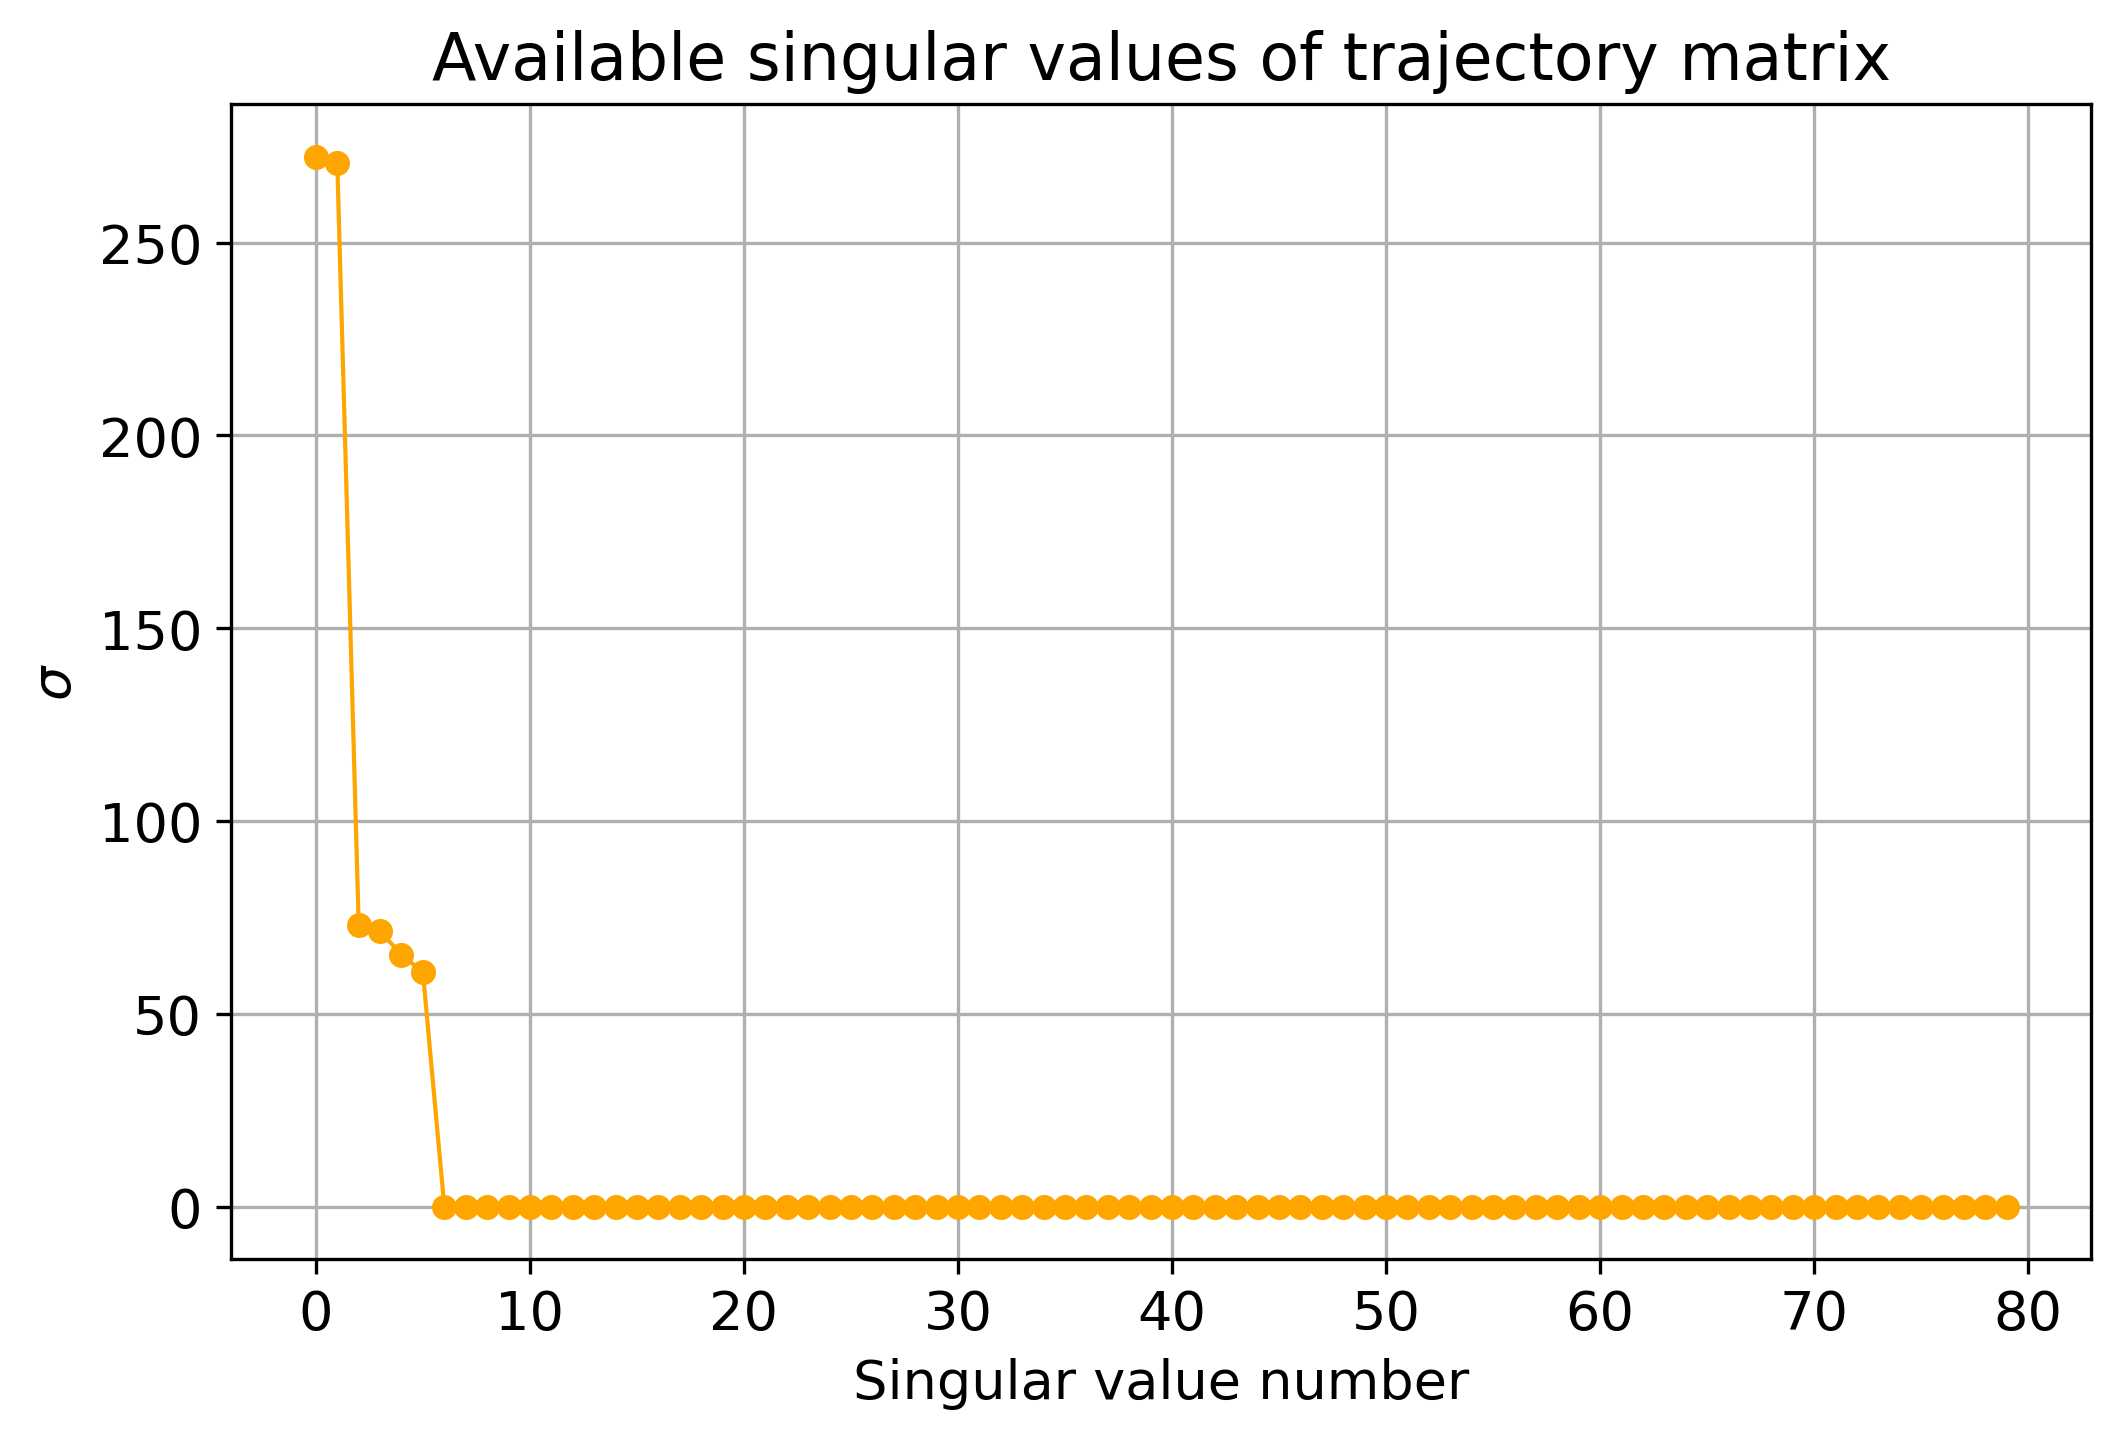

In [4]:
# have a look at singular values
plot_singular_values(ssa_obj.weights, figsize=(8, 5))

In [5]:
# let's remove some of them
ssa_obj.dispose_factors(np.arange(6, len(ssa_obj.weights)))

# check sizes correctness
print(len(ssa_obj.weights))
print(ssa_obj._left_factors.shape[1])
print(ssa_obj._right_factors.shape[0])

6
6
6


(<Figure size 2400x1500 with 1 Axes>,
 <Axes: title={'center': 'Available singular values of trajectory matrix'}, xlabel='Singular value number', ylabel='$\\sigma$'>)

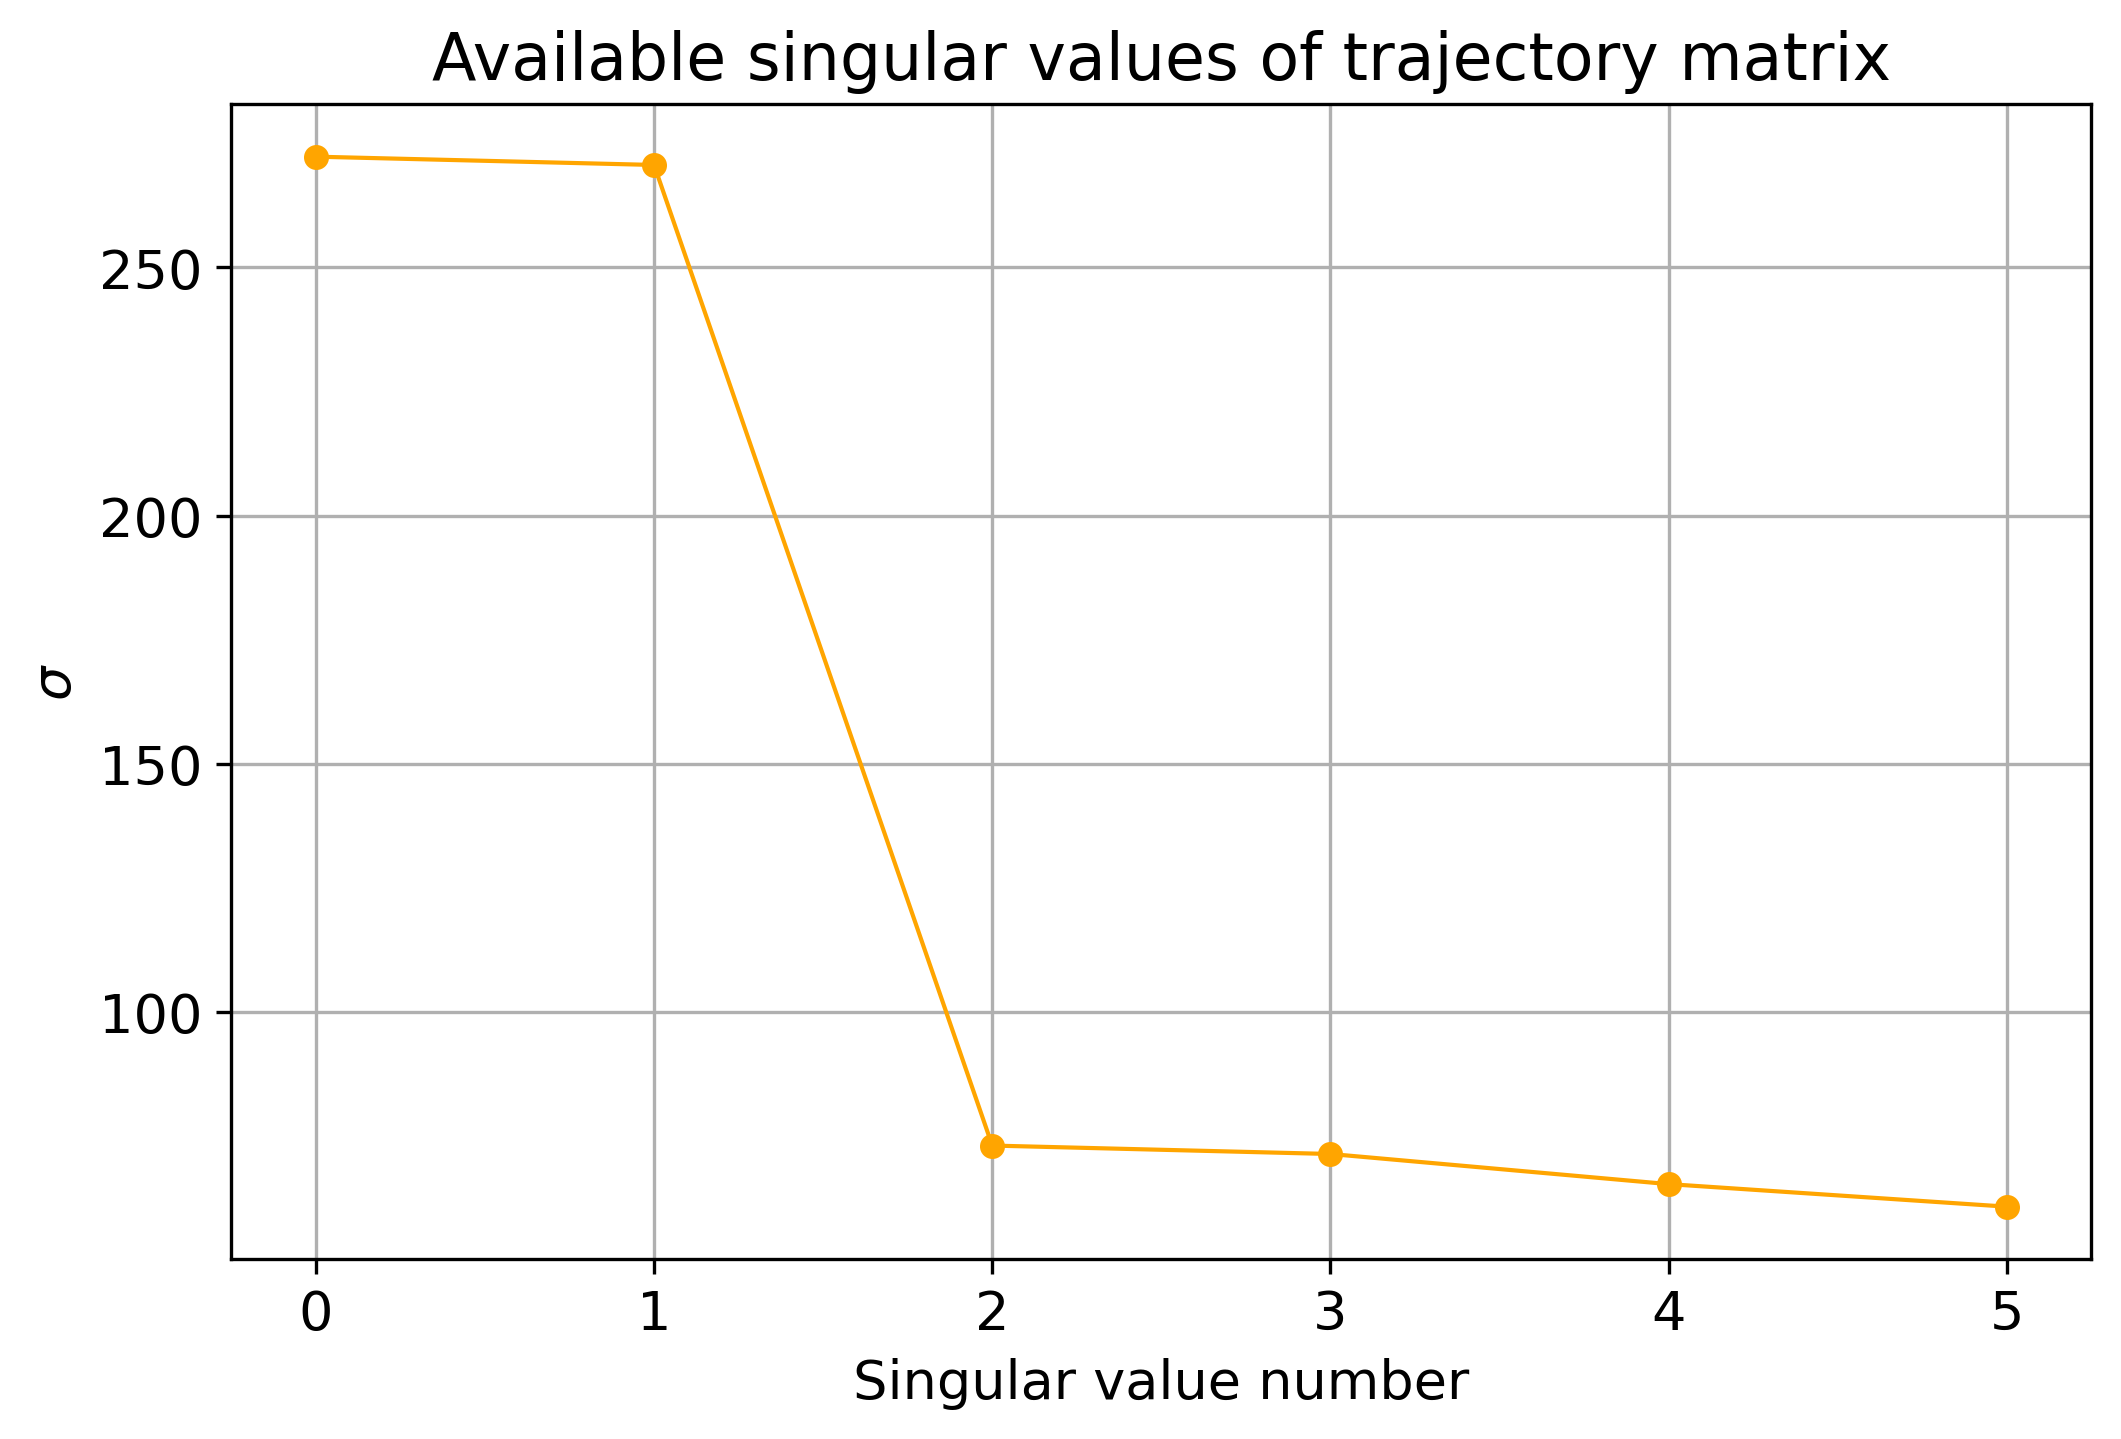

In [6]:
plot_singular_values(ssa_obj.weights, figsize=(8, 5))

### Decomposition

In [7]:
# from the ssa_methods.ssa_complementary.ssa_classic_partition obtain global variables
global _best_found_grouping
global _best_integral_hankel_resid

In [8]:
# trying local search from the singuar value approximation
ssa_obj.set_factors_grouping([])
local_search_partitioning(ssa_obj, [[0, ], [1, 2, 3, 4, 5]], 2)

print(f'Cur best partition score = {get_best_integral_hankel_resid()}')
print(f'Cur best grouping = {get_best_found_grouping()}')

Iteration 1
Moved element 1; consumed time = 1.3436501026153564
Moved element 2; consumed time = 1.3095245361328125
Moved element 3; consumed time = 1.3774640560150146
Moved element 4; consumed time = 1.306727409362793
Moved element 5; consumed time = 1.2869086265563965
Iteration 2
Moved element 0; consumed time = 1.293513536453247
Moved element 1; consumed time = 1.2573199272155762
Moved element 2; consumed time = 1.285095453262329
Moved element 3; consumed time = 1.2565665245056152
Moved element 4; consumed time = 1.3129479885101318
Moved element 5; consumed time = 1.3453240394592285
Cur best partition score = 5.427192687988281
Cur best grouping = [[0, 1], [2, 3, 4, 5]]


In [9]:
ssa_obj.set_factors_grouping(get_best_found_grouping())
components, resids_abs, resids_rel = ssa_obj.decompose_signal()

# print residuals info
print(f'Absolute residual values: {resids_abs}\nMean absolute residual = {np.mean(resids_abs)}')
print(f'Relative residual values: {resids_rel}\nMean reletive residual = {np.mean(resids_rel)}')

Absolute residual values: [5.42719269 5.42719269]
Mean absolute residual = 5.427192687988281
Relative residual values: [0.01413681 0.03999656]
Mean reletive residual = 0.027066684784531204


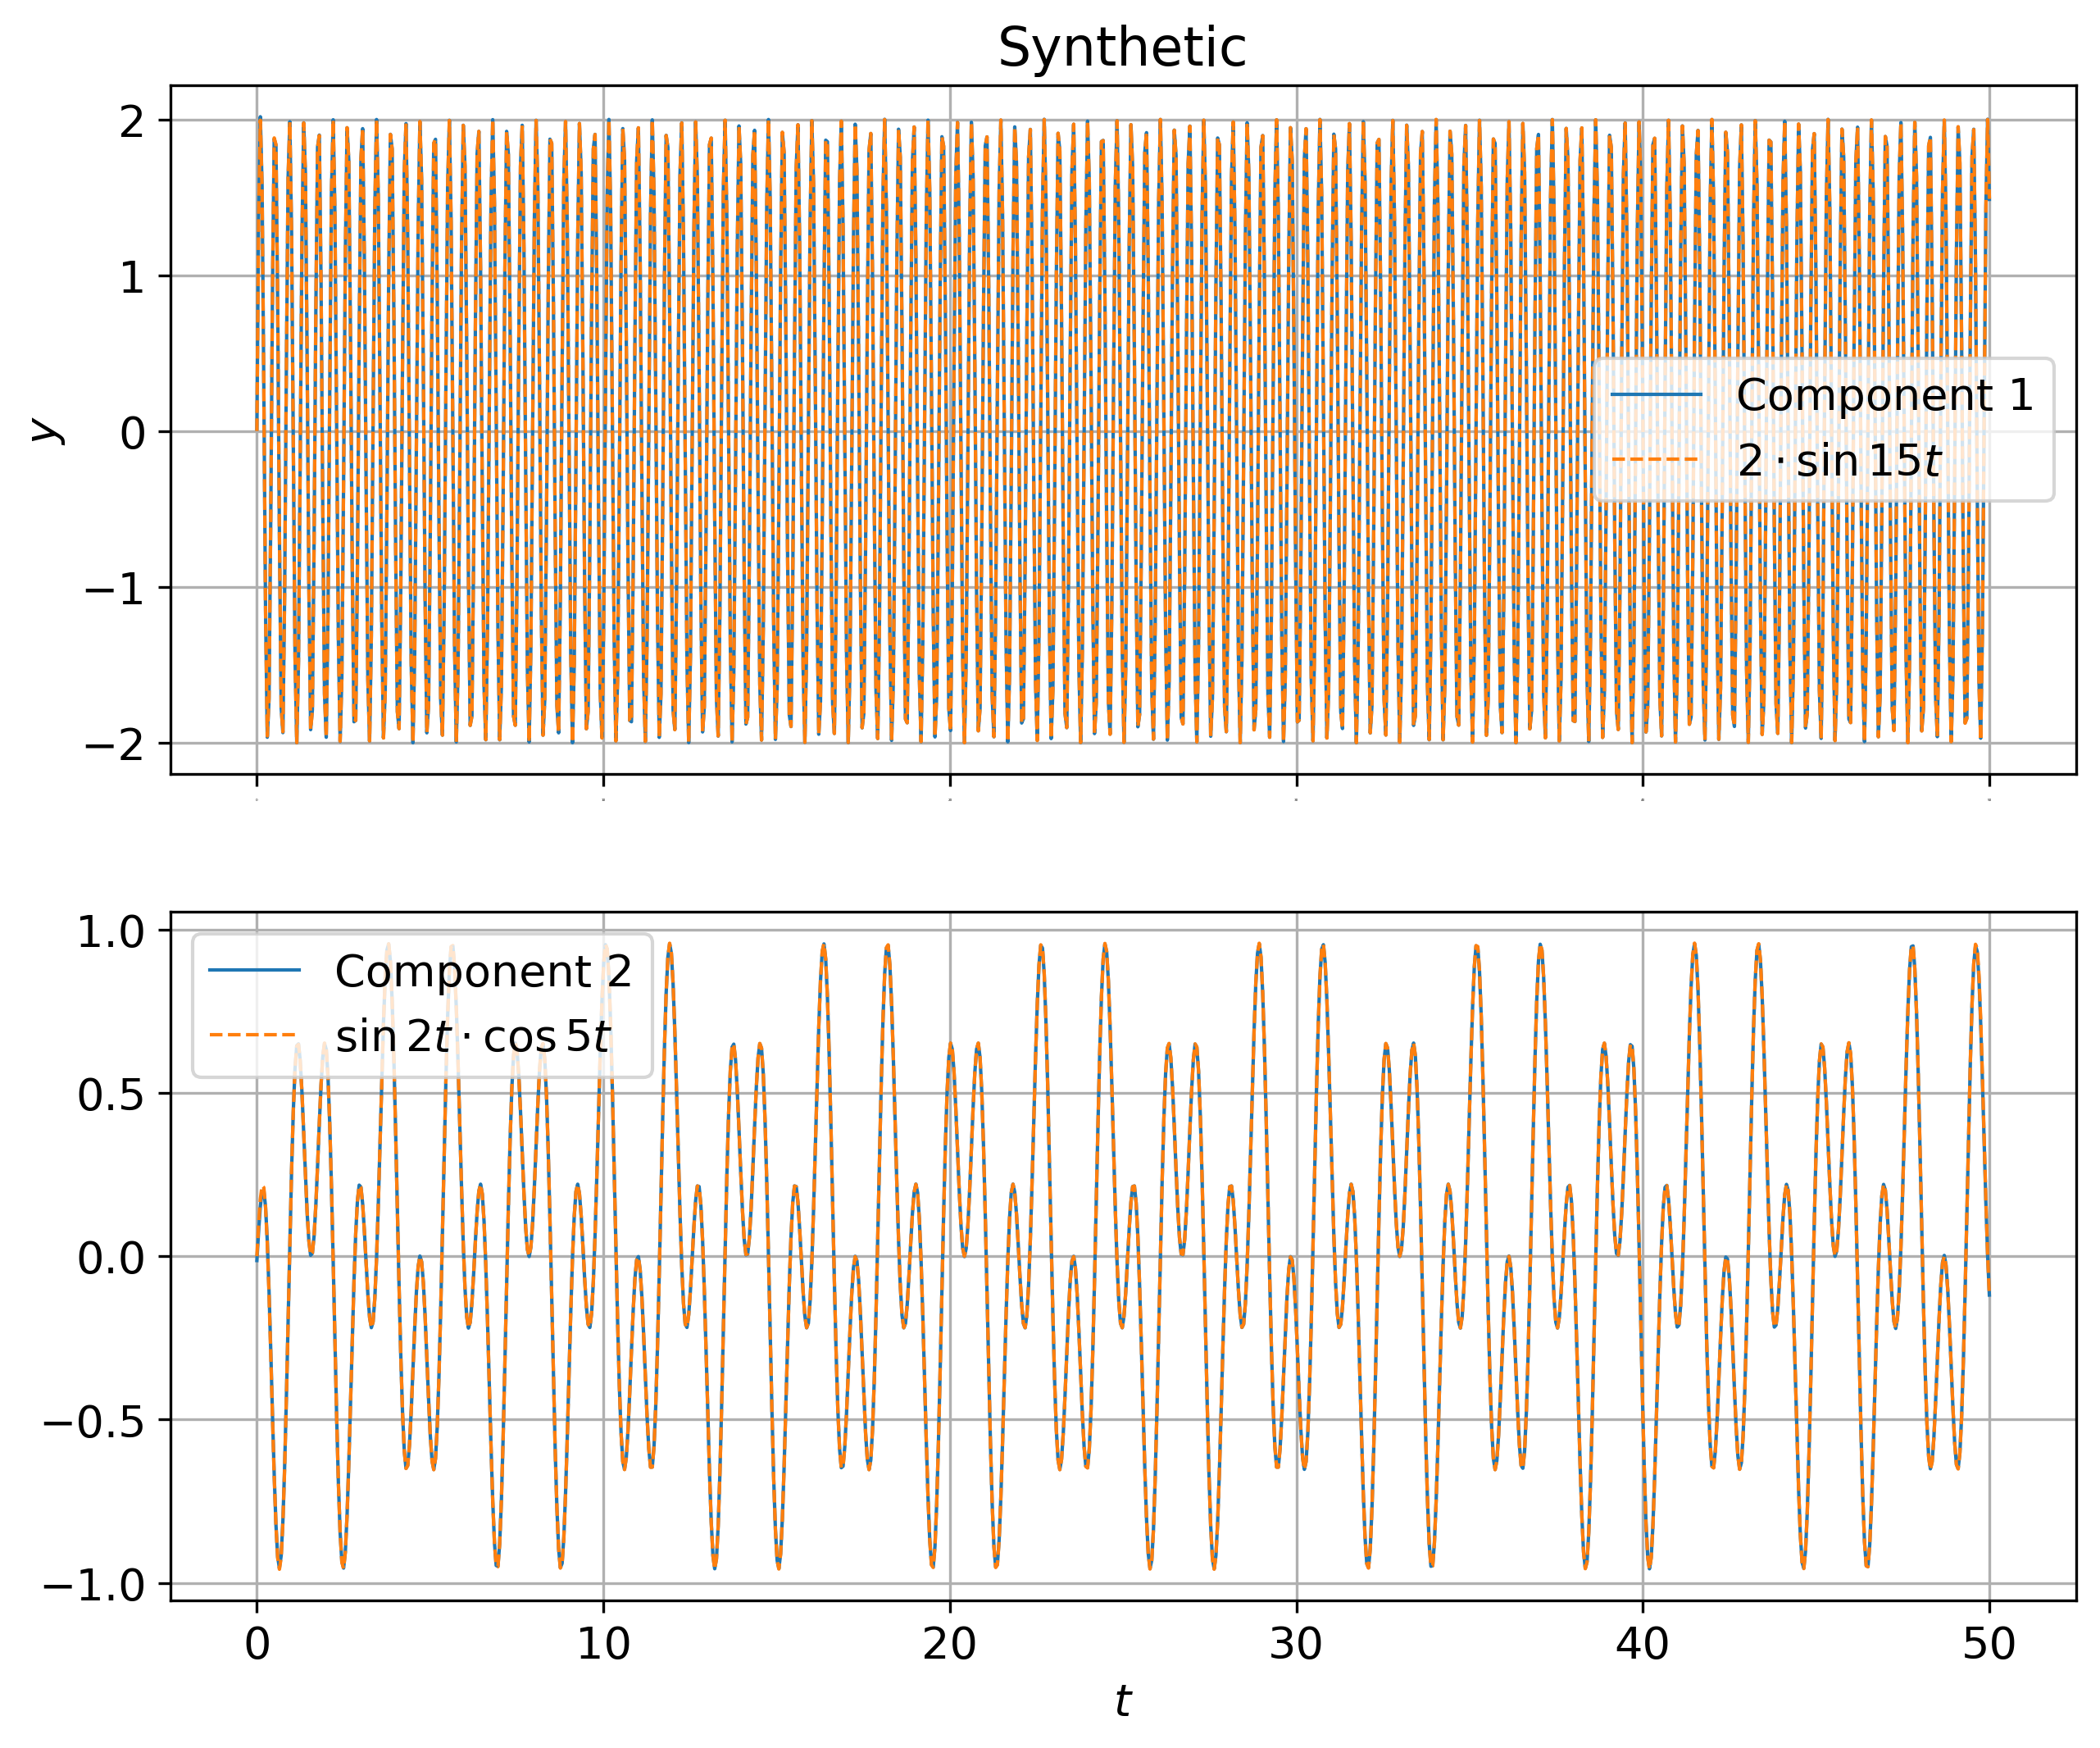

In [10]:
# plot decomposition
fig, axs = plot_component_signals(time_grid, components, 'Synthetic', figsize=(10, 8))

axs[0].plot(time_grid, 2 * np.sin(15 * time_grid), label='$2 \\cdot \\sin 15t$', linestyle='--')
axs[0].legend()

axs[1].plot(time_grid, np.sin(2 * time_grid) * np.cos(5 * time_grid), label='$\\sin2t \\cdot \\cos 5t$', linestyle='--')
axs[1].legend()

### Prediction

In [11]:
# test methods
print(ssa_obj.get_prediction())
ssa_obj.remove_last_prediction(1)

[]


ValueError: Deleting more values then available.

Prediction for k = 1 is [-0.018353176253733727, -1.4475037856423556, -2.1663657015146587, -1.783460262855777, -0.48337203395227935, 1.0662212325659572]
Prediction for k = 2 is [-0.018353176253732874, -1.4475037856423554, -2.1663657015146565, -1.783460262855777, -0.4833720339522773, 1.0662212325659577]
Prediction for k = 3 is [-0.018353176253731146, -1.4475037856423554, -2.1663657015146587, -1.7834602628557745, -0.4833720339522779, 1.0662212325659577]


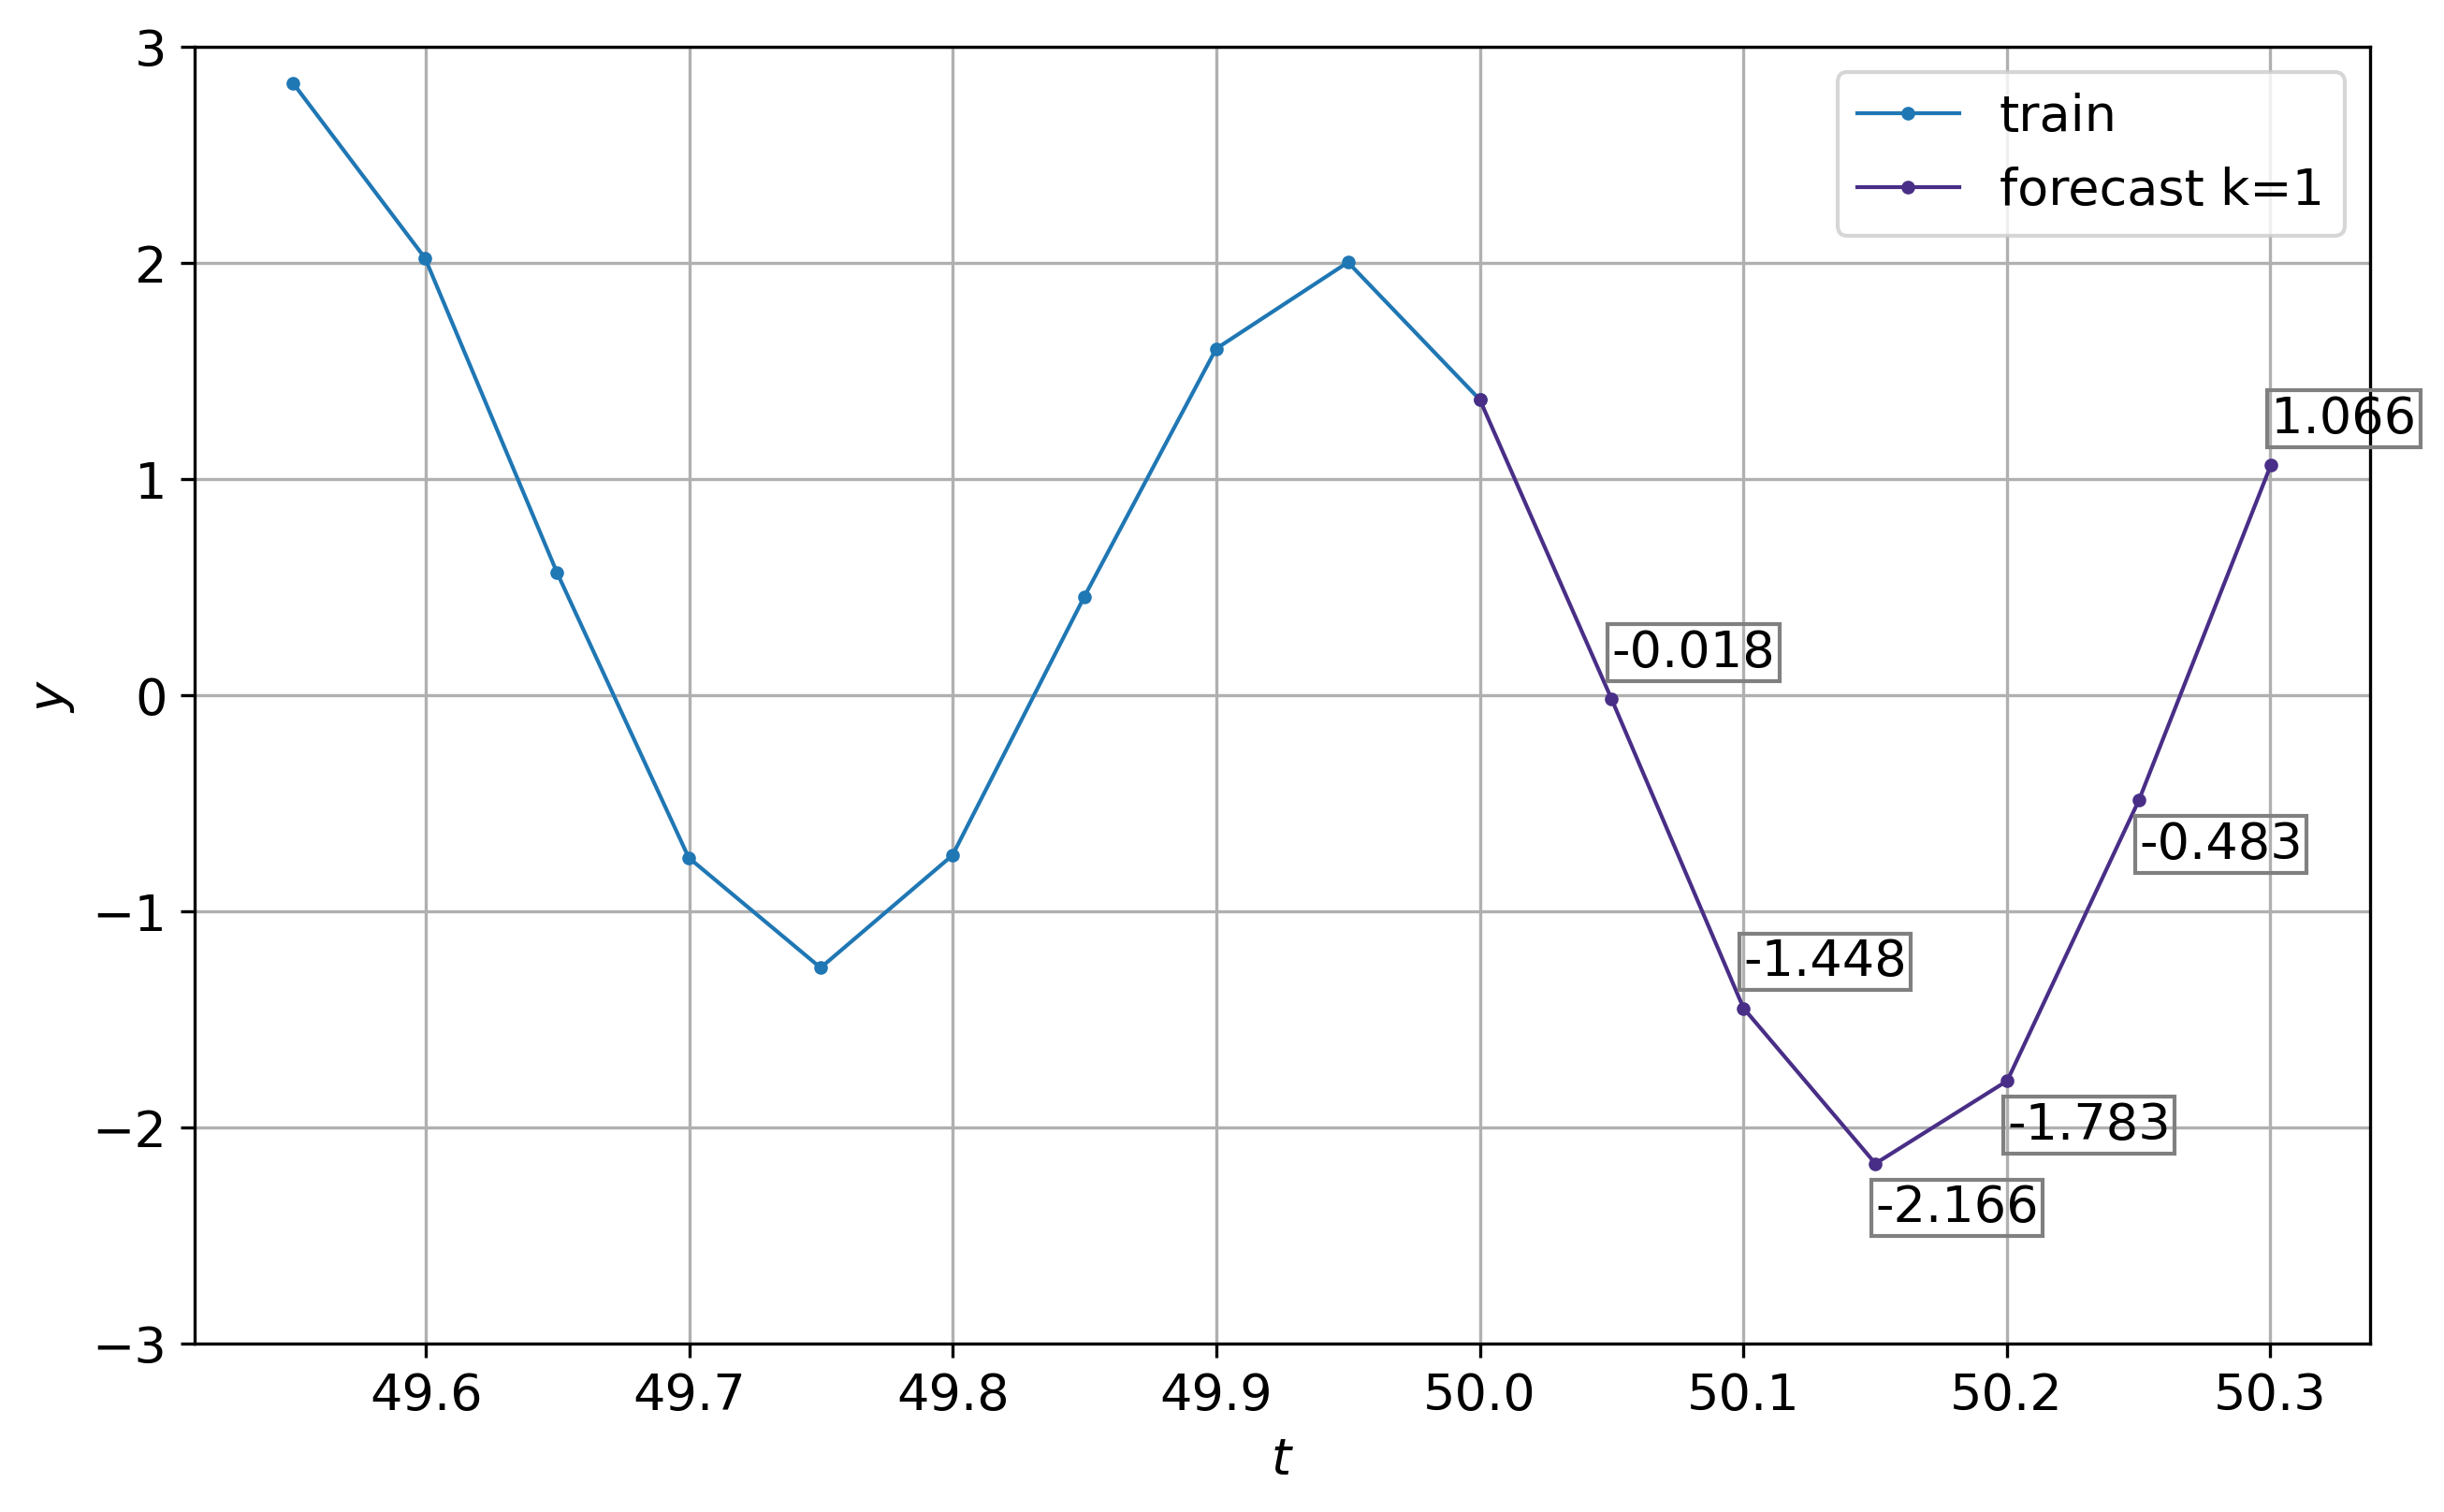

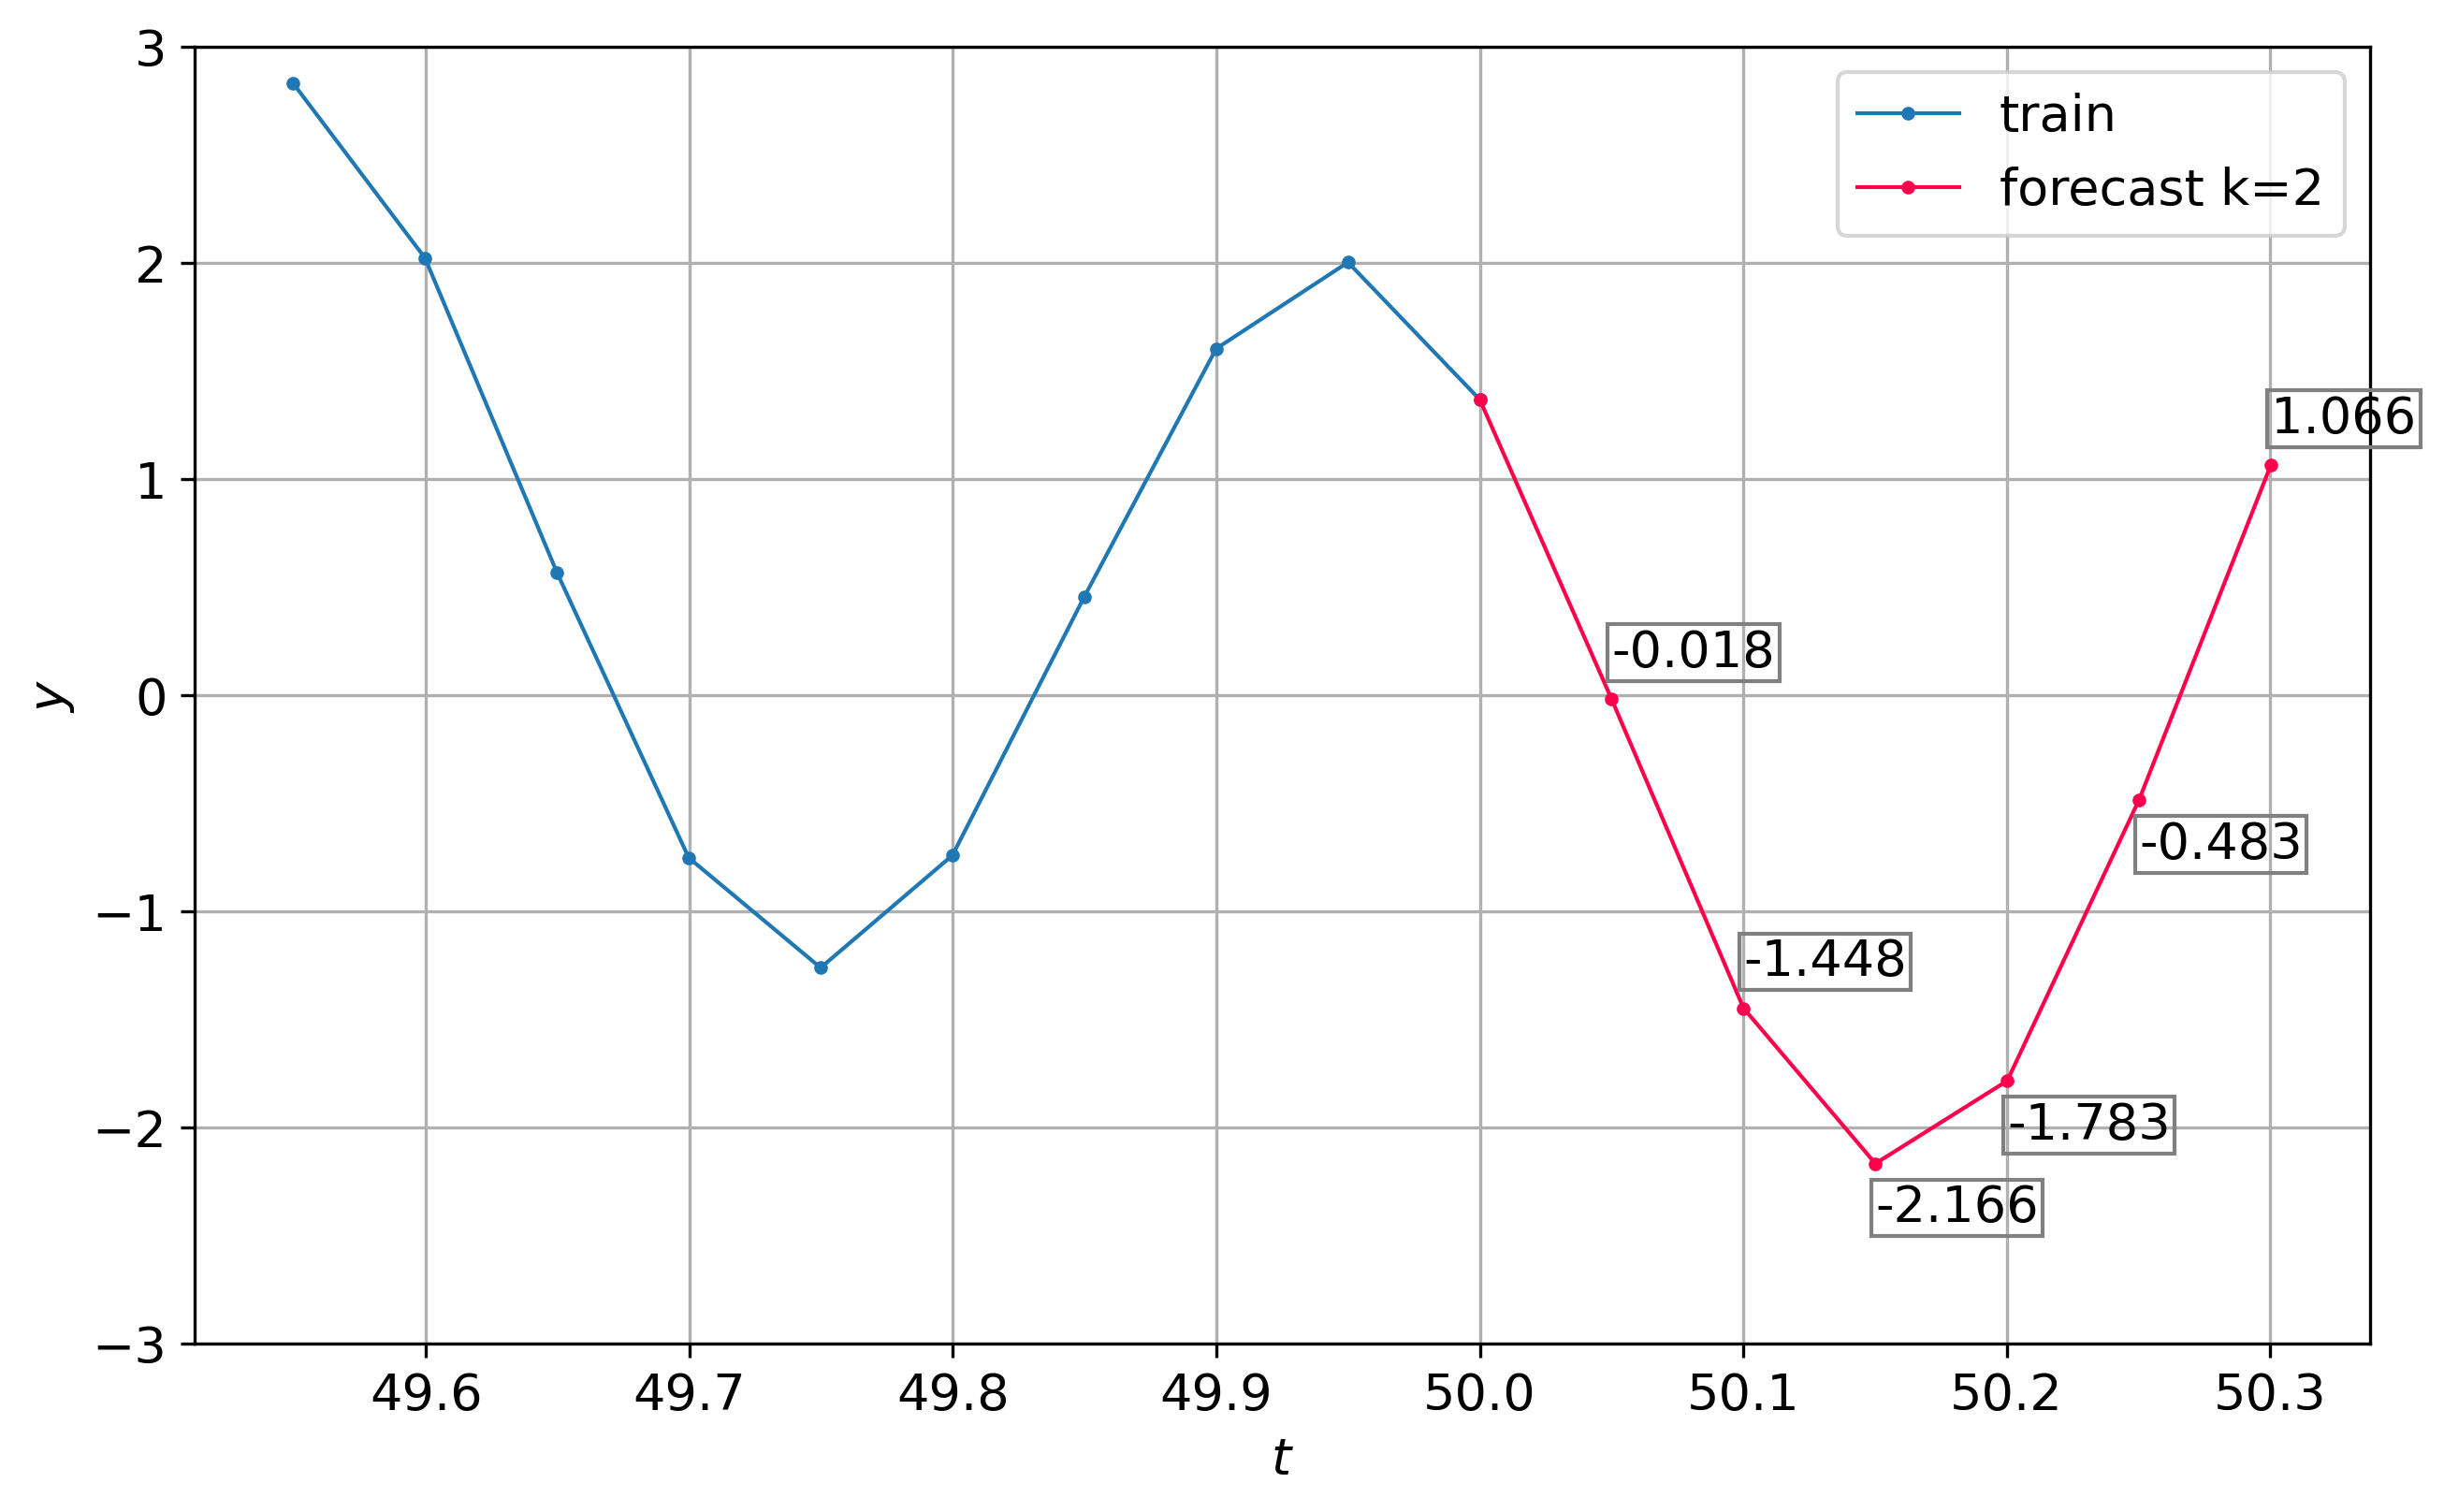

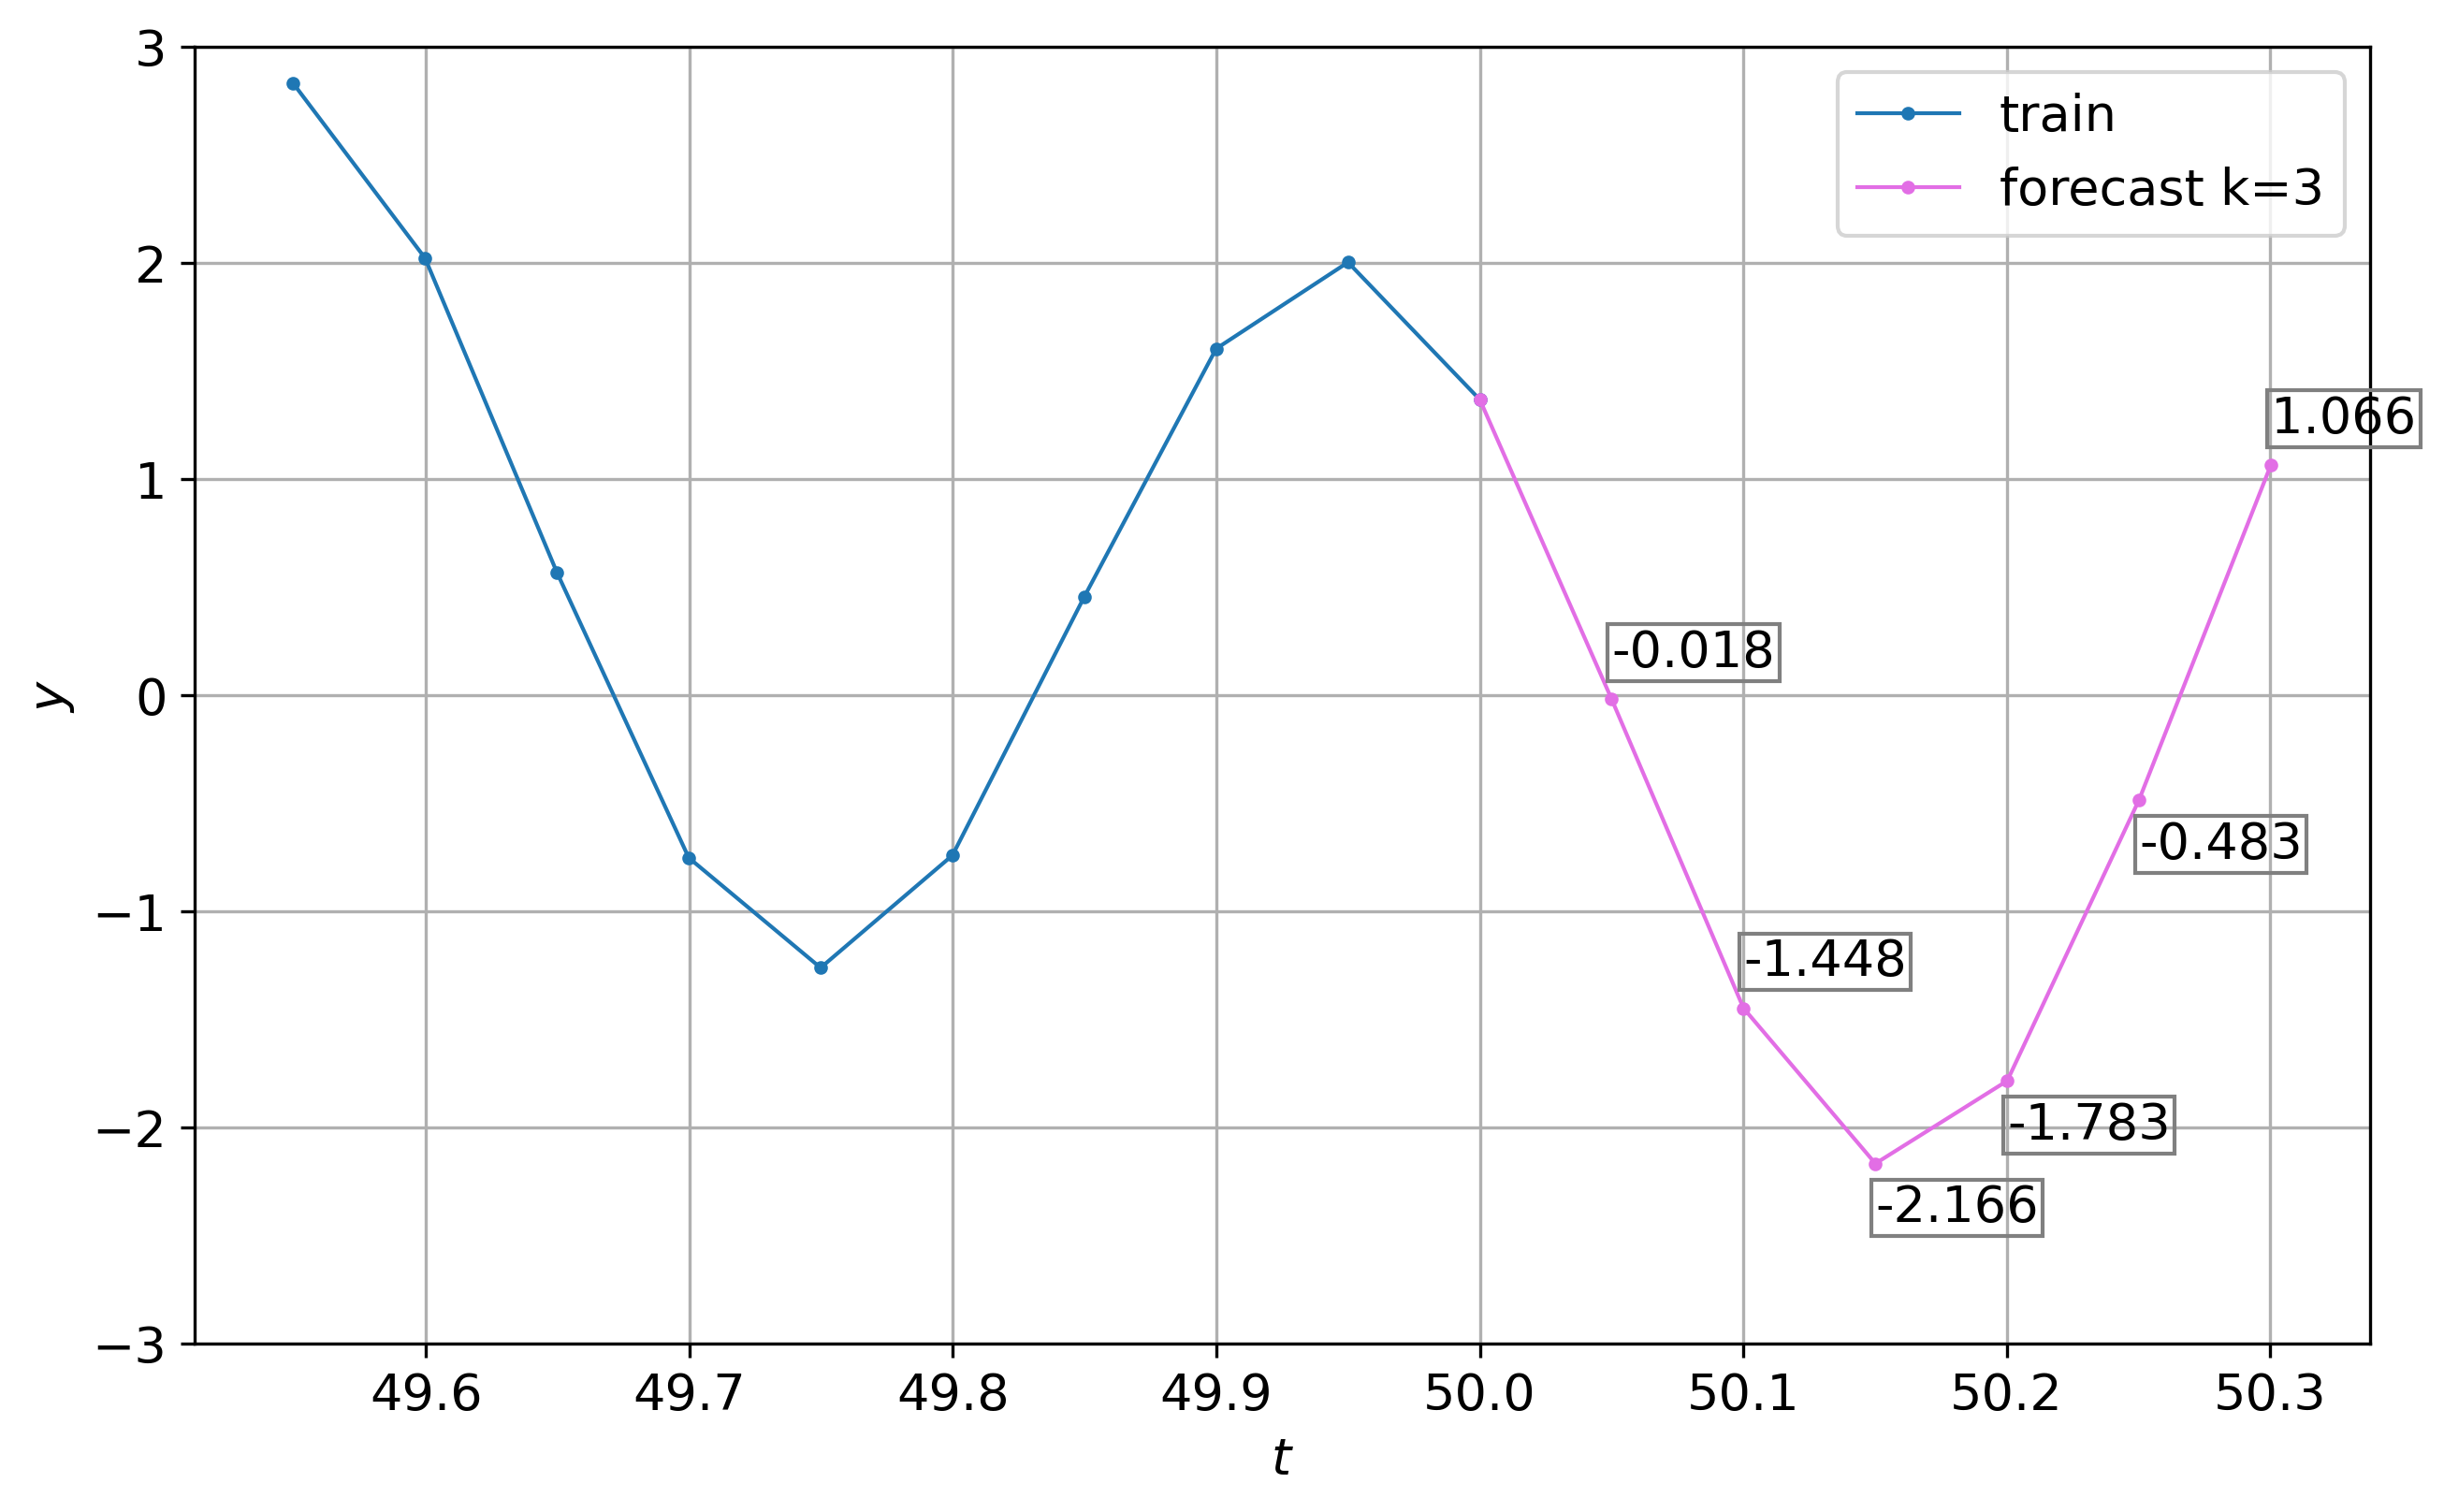

In [18]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 13})
plt.rcParams.update({'lines.linewidth': 1})

ssa_obj.remove_last_prediction()

last_known_values_edge = 10
last_known_values = ssa_obj.t_s[-last_known_values_edge:]
last_values_time_grid = time_grid[-last_known_values_edge:]

lines_colors = ['#492E87', '#FF004D', '#E26EE5']
# prediction horizon
tot_pred = 6

# obtaining predictions for diffrent horizions from last known point
for k in range(1, 3 + 1):
    cur_prediction = []

    for j in range(tot_pred // k):
        try:
            cur_prediction.extend(ssa_obj.predict_next(k)) 
        except Exception as ex:
            print(ex.args)
            continue

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlabel('$t$')
    ax.set_ylabel('$y$')
    ax.grid(True)

    ax.set_ylim(-3, 3)

    ax.plot(last_values_time_grid, last_known_values, label='train', marker='.', markersize=5)

    time_grid_extension = np.linspace(time_grid[-1], time_grid[-1] + tot_pred * time_grid[1], tot_pred + 1)
    t_s_extension = np.concatenate([np.array([ssa_obj.t_s[-1]]), cur_prediction], axis=0)

    # text labels near predicition points
    for i in range(tot_pred):
        if i >= 2 and i <= 4:
            ax.text(time_grid_extension[1 + i], cur_prediction[i] - 0.27, f"{cur_prediction[i]:.3f}",
                bbox={'edgecolor': 'grey', 'pad': 1, 'fill': False})
        else:
            ax.text(time_grid_extension[1 + i], cur_prediction[i] + 0.15, f"{cur_prediction[i]:.3f}",
                bbox={'edgecolor': 'grey', 'pad': 1, 'fill': False})

    ax.plot(time_grid_extension, t_s_extension, label=f'forecast k={k}',
             marker='.', markersize=5, color=lines_colors[k - 1])
    ax.legend()

    fig.savefig(f'../figs/experiment/ssa_classic_prediction_invariant/forecast{k}.png', format='png', dpi=300)

    print(f'Prediction for k = {k} is {cur_prediction}')

    ssa_obj.remove_last_prediction(tot_pred)


('illegal value in 4-th argument of internal getrf|getri',)

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGETRF.
Prediction for k = 1 is [-0.01835318]
Prediction for k = 2 is [-0.01835318 -1.44750379]
Prediction for k = 3 is [-0.01835318 -1.44750379 -2.1663657 ]
Prediction for k = 4 is [-0.01835318 -1.44750379 -2.1663657  -1.78346026]


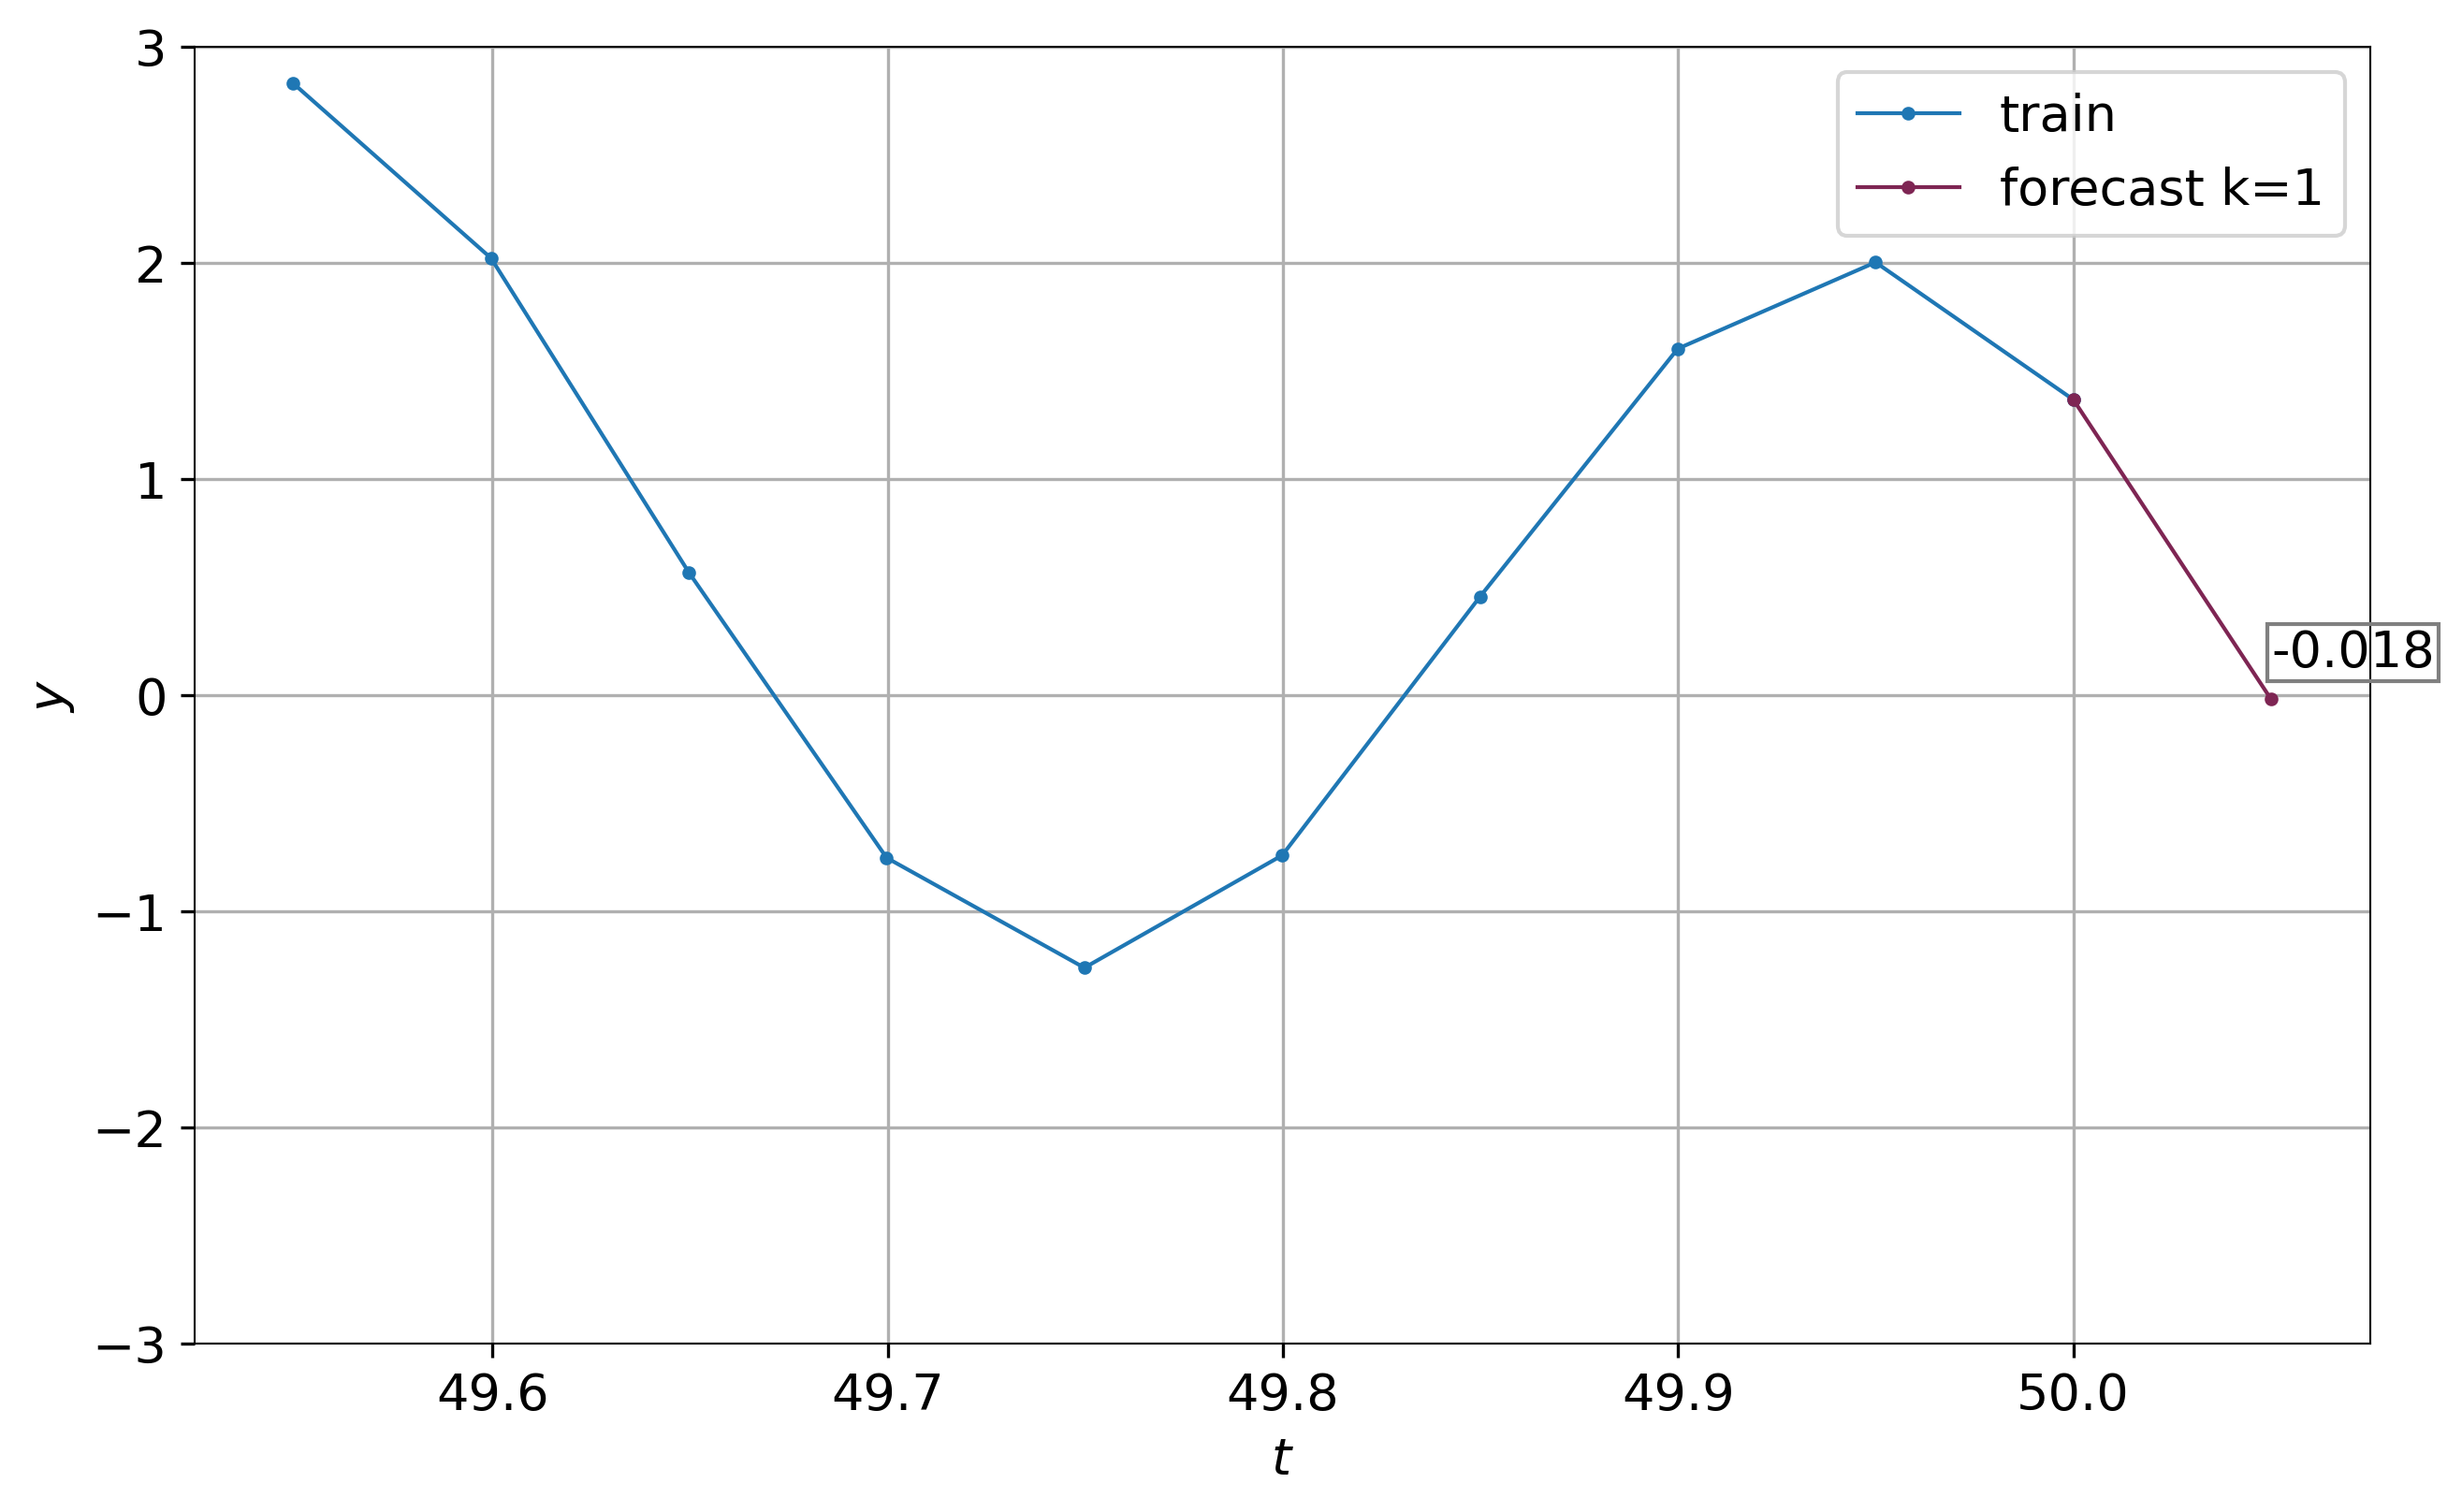

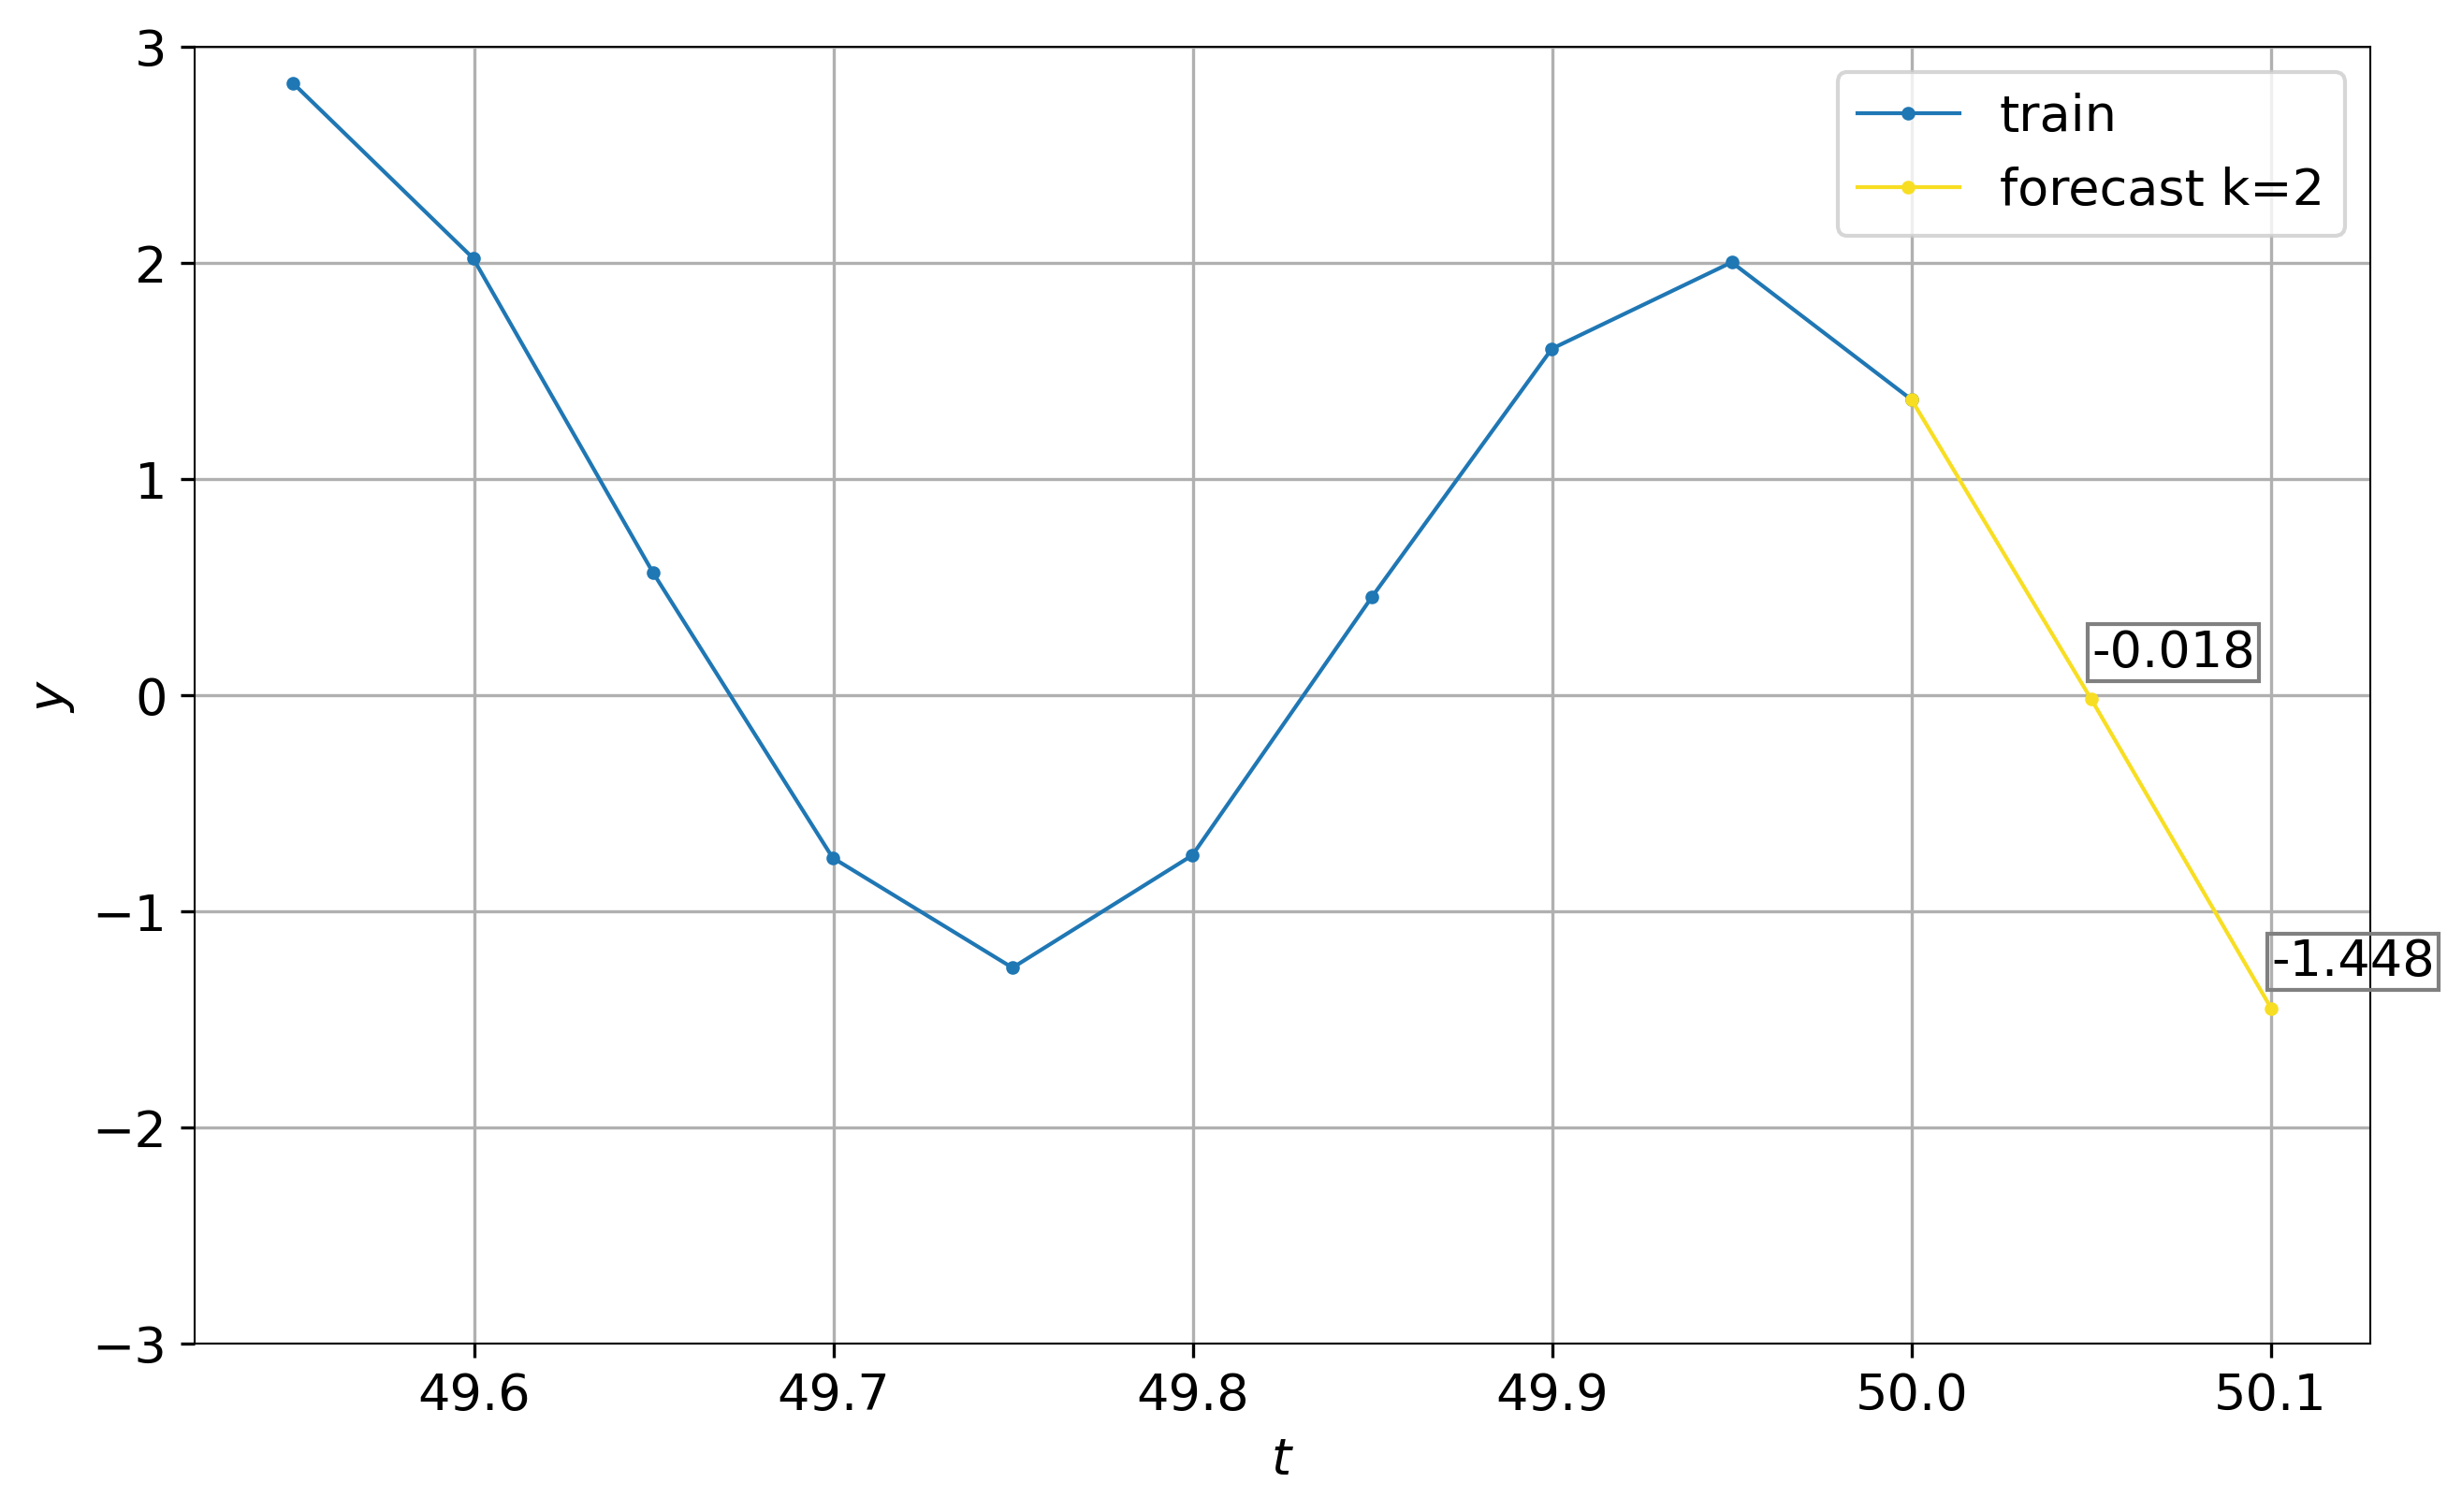

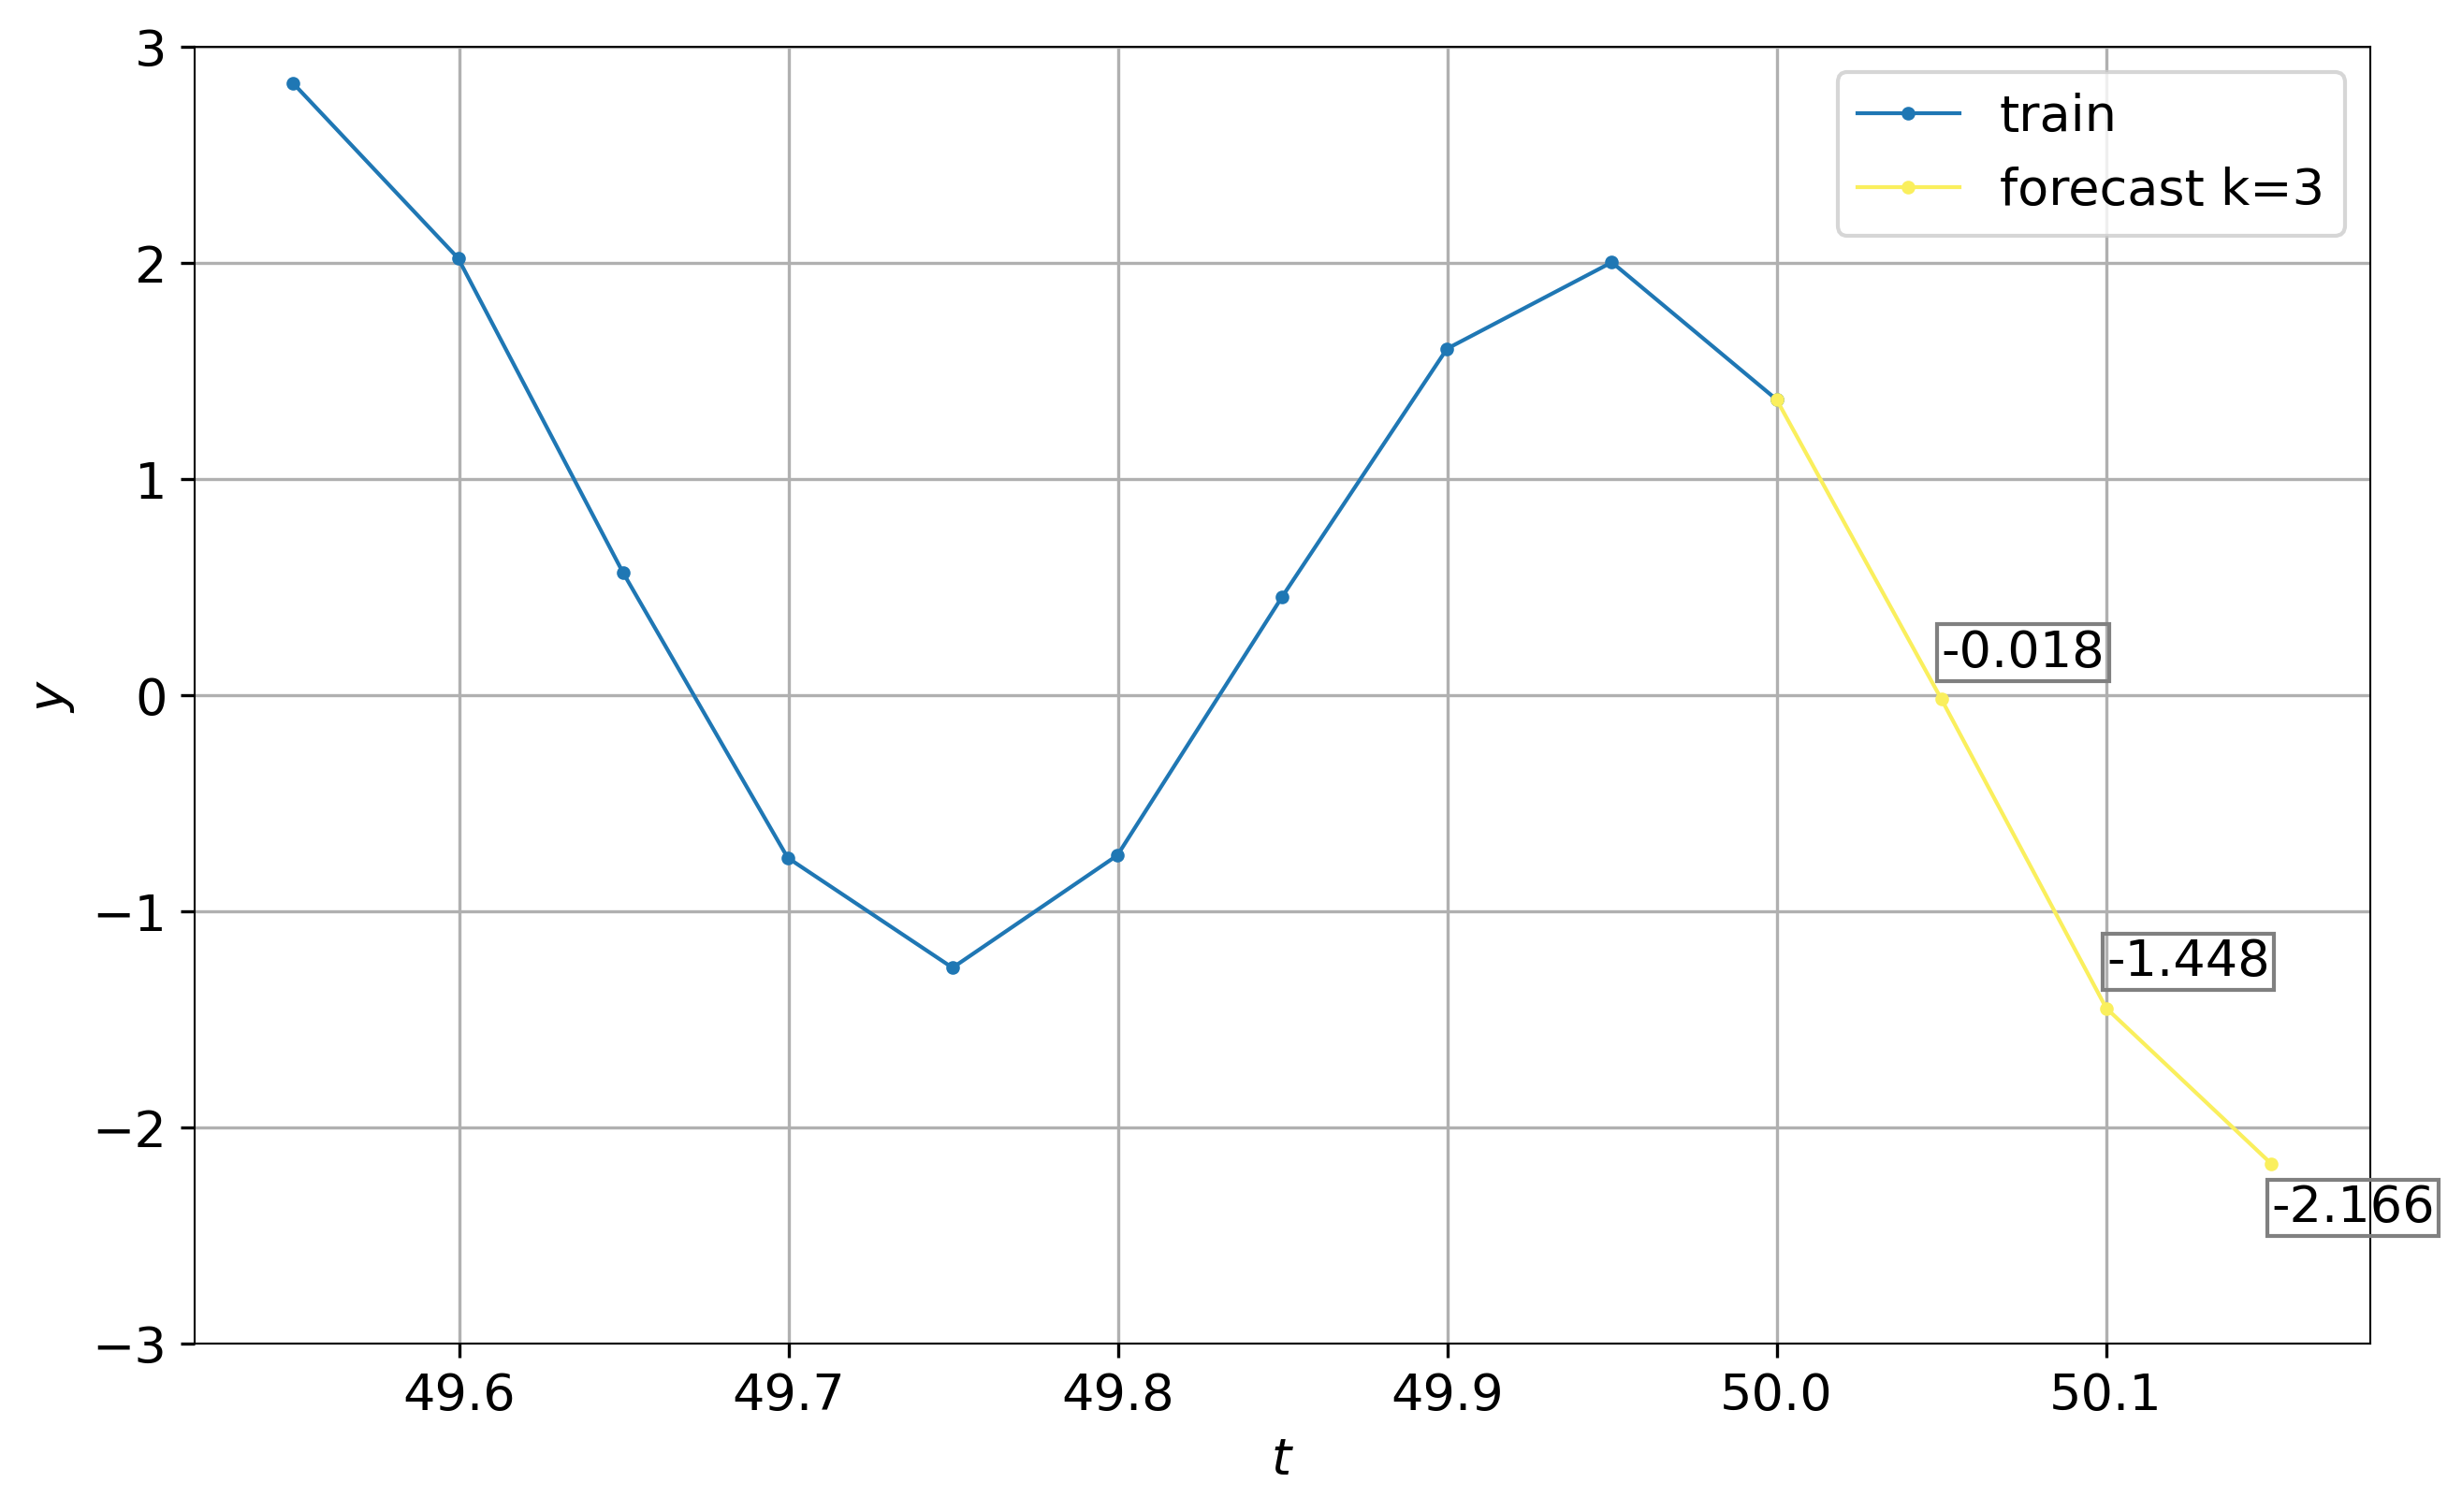

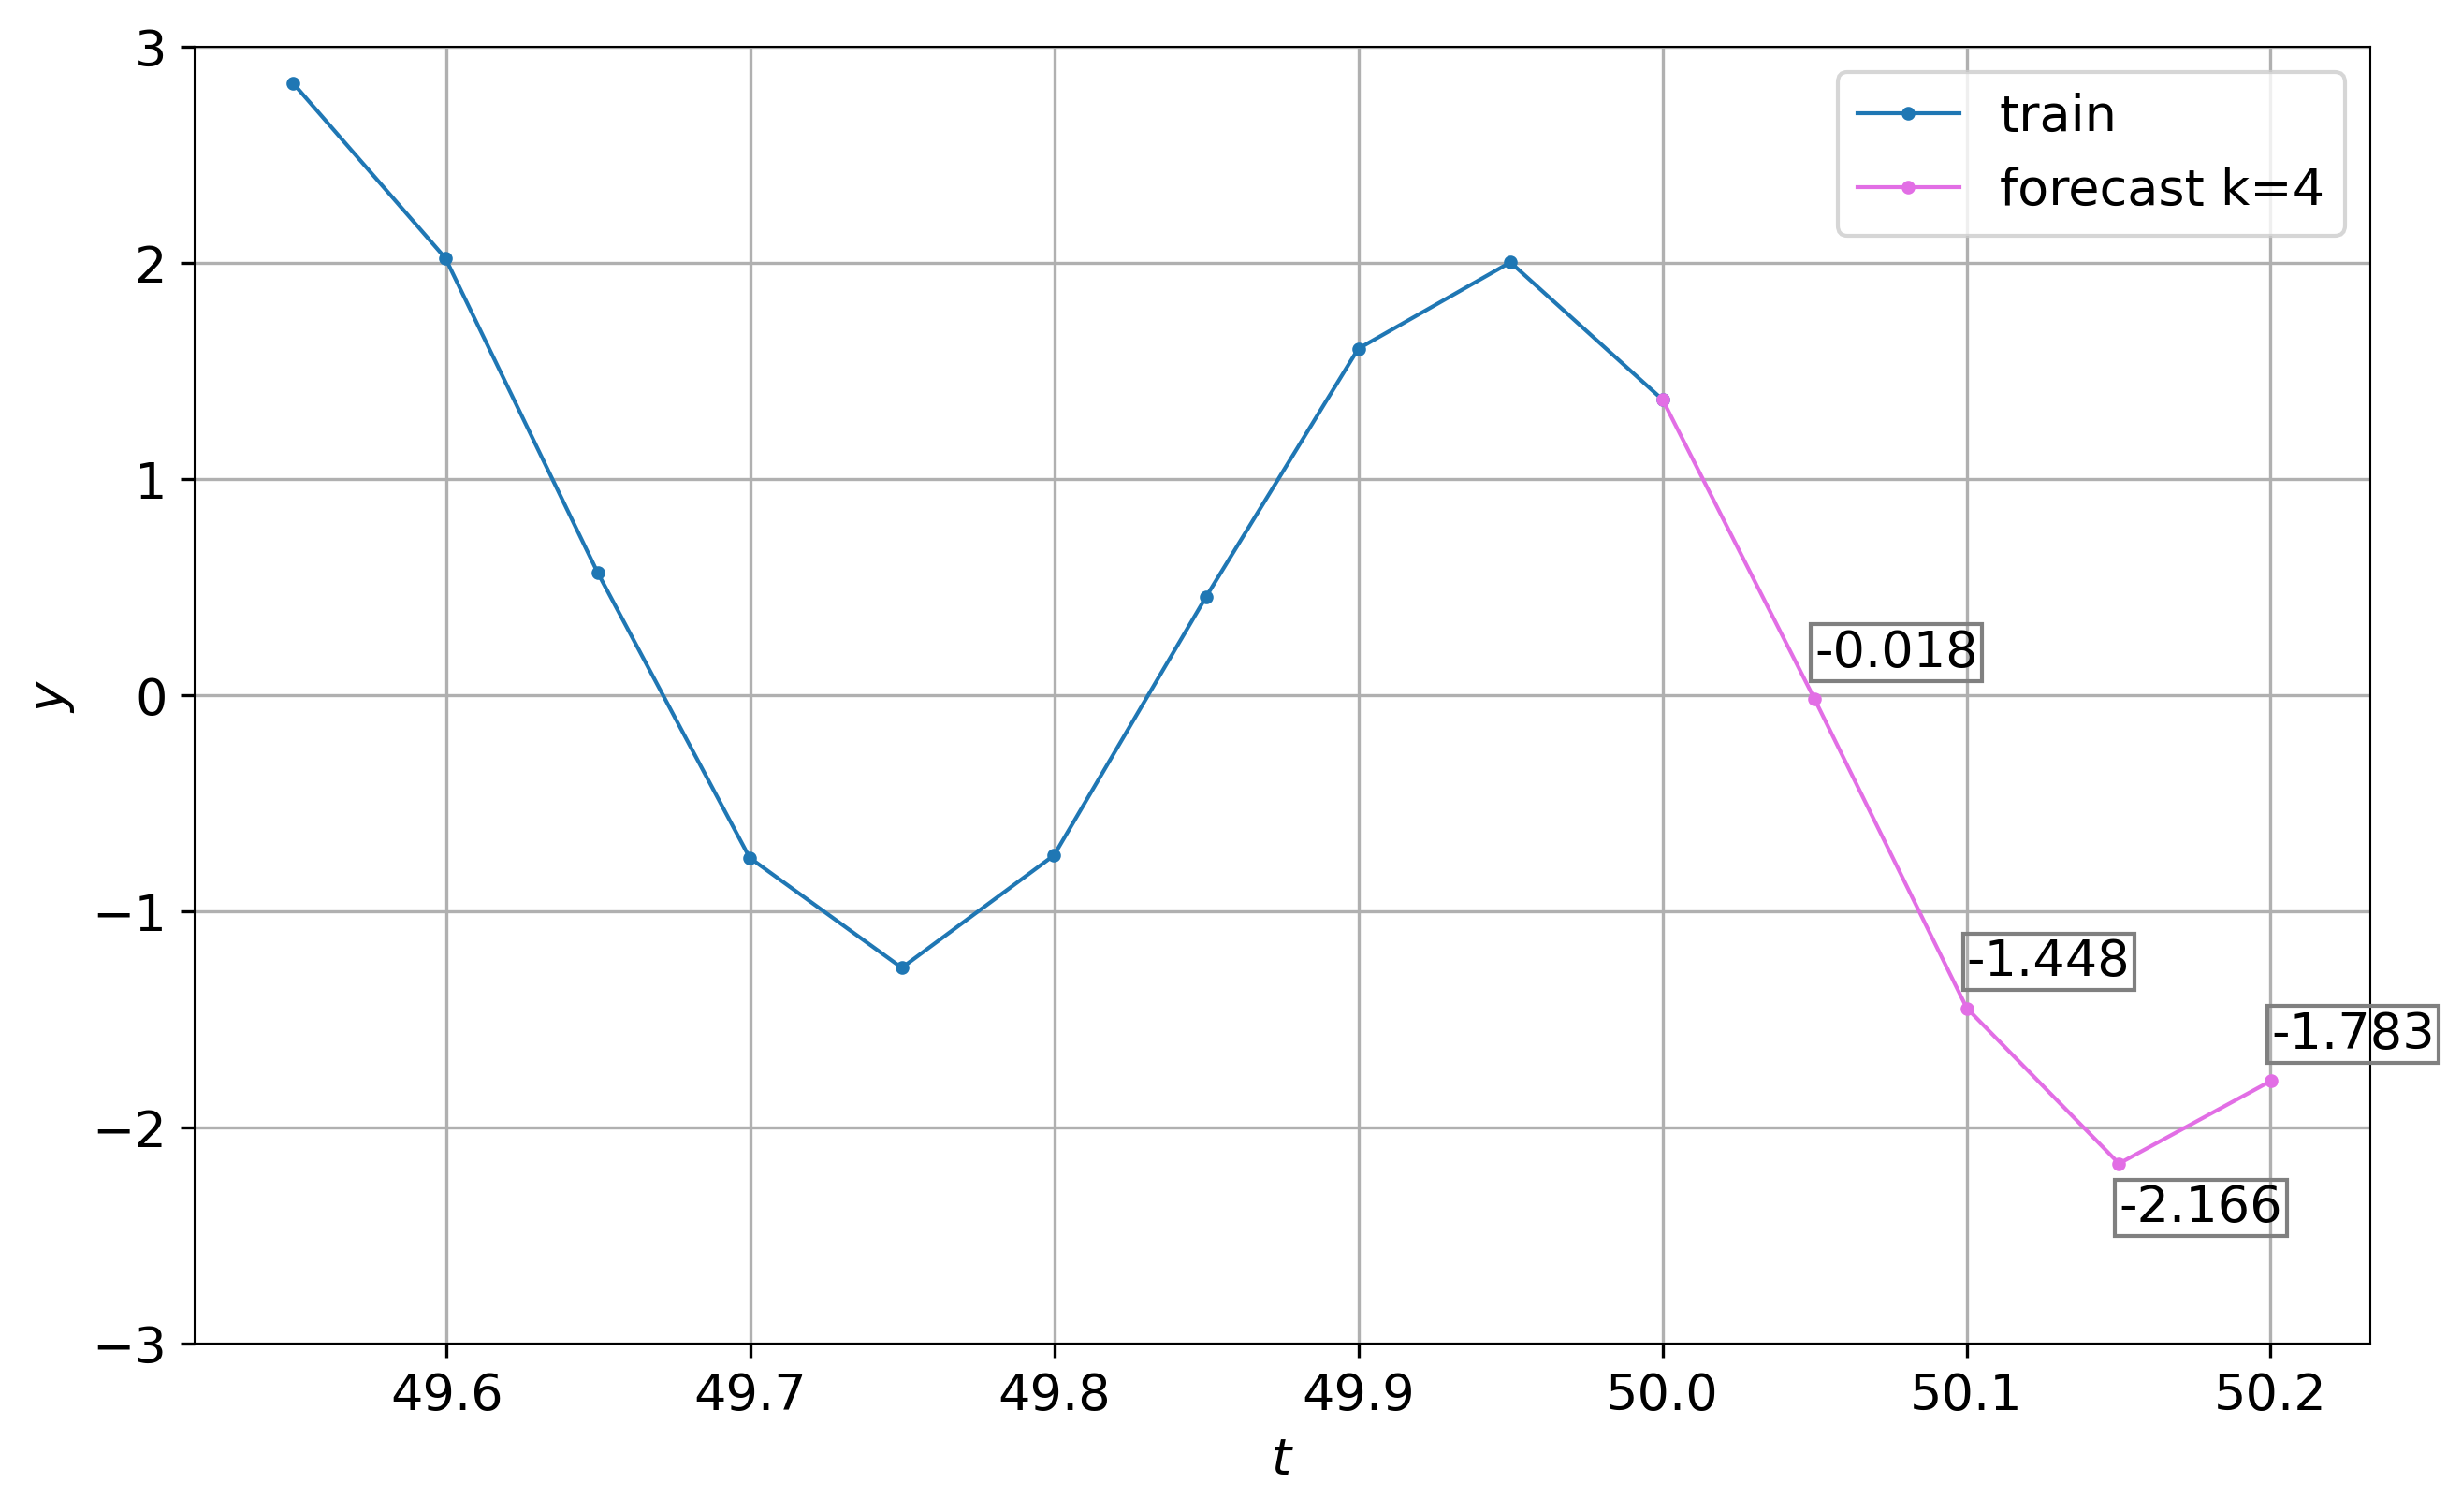

In [99]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 13})
plt.rcParams.update({'lines.linewidth': 1})

ssa_obj.remove_last_prediction()

last_known_values_edge = 10
last_known_values = ssa_obj.t_s[-last_known_values_edge:]
last_values_time_grid = time_grid[-last_known_values_edge:]

lines_colors = ['#1D2B53', '#7E2553', '#F8DE22', '#FAEF5D', '#E26EE5']

# obtaining predictions for diffrent horizions from last known point
for k in range(3):
    try:
        cur_prediction = ssa_obj.predict_next(k)
    except Exception as ex:
        print(ex.args)
        continue

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlabel('$t$')
    ax.set_ylabel('$y$')
    ax.grid(True)

    ax.set_ylim(-3, 3)

    ax.plot(last_values_time_grid, last_known_values, label='train', marker='.', markersize=5)

    time_grid_extension = np.linspace(time_grid[-1], time_grid[-1] + k * time_grid[1], k + 1)
    t_s_extension = np.concatenate([np.array([ssa_obj.t_s[-1]]), cur_prediction], axis=0)

    # text labels near predicition points
    for i in range(k):
        if i == 2:
            ax.text(time_grid_extension[1 + i], cur_prediction[i] - 0.27, f"{cur_prediction[i]:.3f}",
                bbox={'edgecolor': 'grey', 'pad': 1, 'fill': False})
        else:
            ax.text(time_grid_extension[1 + i], cur_prediction[i] + 0.15, f"{cur_prediction[i]:.3f}",
                bbox={'edgecolor': 'grey', 'pad': 1, 'fill': False})

    ax.plot(time_grid_extension, t_s_extension, label=f'forecast k={k}',
             marker='.', markersize=5, color=lines_colors[k])


    print(f'Prediction for k = {k} is {cur_prediction}')

    ssa_obj.remove_last_prediction(k)

    ax.legend()

    fig.savefig(f'../figs/experiment/ssa_classic_prediction_invariant/forecast{k}.png', format='png')


Few first predictions: [-0.018353176253733727, -1.4475037856423556, -2.1663657015146587, -1.783460262855777, -0.48337203395227935, 1.0662212325659572]


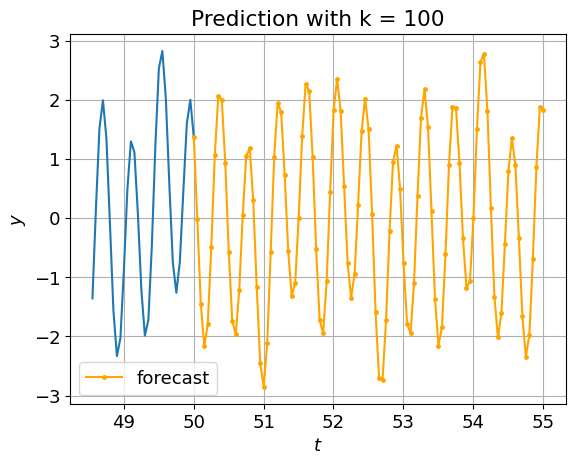

In [25]:
ssa_obj.remove_last_prediction()
# get prediction by one step for some horizon
cur_horizon = 100
for i in range(cur_horizon):
    try:
        ssa_obj.predict_next(1)
    except Exception as ex:
        break

time_grid_extension = np.linspace(time_grid[-1], time_grid[-1] + len(ssa_obj.get_prediction()) * time_grid[1], cur_horizon + 1)
t_s_extension = np.concatenate([np.array([ssa_obj.t_s[-1]]), ssa_obj.get_prediction()], axis=0)

_, ax = plot_signal(last_values_time_grid, last_known_values, sig_name=f'Prediction with k = {cur_horizon}')
ax.plot(time_grid_extension, t_s_extension, color='orange', marker='.', ms=5, label='forecast')
ax.legend()

print(f'Few first predictions: {ssa_obj.get_prediction()[:6]}')